# CLASE 2.7: Métodos de ensamble
---
## Introducción.
En la sección anterior, exploramos en detalle los árboles de decisión, un tipo de modelo de aprendizaje supervisado que es capaz de aprender reglas de decisión a partir de los datos y aplicarlas de manera interpretativa. Sin embargo, los árboles de decisión presentan ciertos desafíos: Pueden ser altamente sensibles al ruido y al overfitting, y limitados en su capacidad de generalización.

Para abordar estos problemas, en esta sección exploraremos una de las técnicas más poderosas en aprendizaje automático moderno: Los **métodos de ensamble**. En términos simples, en lugar de depender de un único modelo (cualquiera sea éste), los métodos de ensamble combinan múltiples modelos más simples para crear un modelo más fuerte y robusto. Esto nos permite reducir la varianza, mejorar la precisión y aumentar la estabilidad de las predicciones.

Los métodos de ensamble aprovechan la idea de que **varios modelos débiles pueden acoplarse para crear un modelo fuerte**. En otras palabras, cada modelo base puede cometer errores en diferentes partes del espacio de entrada, pero al combinar sus predicciones de manera "inteligente", podemos construir un modelo "colectivo" que generalice mejor que cualquiera de sus componentes individuales.

Entre los enfoques más populares que estudiaremos en esta sección, tenemos:

- **Voting (votación por mayoría o ponderada):** Método simple pero poderoso en el que combinamos múltiples modelos de distinto tipo (por ejemplo, árboles de decisión, regresión logística y máquinas de soporte vectorial) y tomamos la predicción final basada en un voto mayoritario (clasificación) o un promedio ponderado (regresión).

- **Bagging (acrónimo del inglés *bootstrap aggregating*):** Técnica en la que entrenamos múltiples modelos en subconjuntos aleatorios de los datos de entrenamiento y combinamos sus predicciones de una manera agregada (por ejemplo, promediándolas o usando su moda). El ejemplo más conocido de esta técnica de ensamble es el **modelo de bosque aleatorizado** o **random forest**, y que comúnmente se considera una extensión "natural" de los modelos de árbol de decisión.

- **Boosting:** Enfoque similar al anterior, pero en el cual los modelos se entrenan secuencialmente, corrigiendo los errores de los modelos anteriores en un proceso más bien progresivo. Modelos tales como **Gradient Boosting Machines (GBM)**, **AdaBoost** y **XGBoost** han demostrado ser extremadamente eficaces en competencias de Machine Learning y aplicaciones industriales, y por lo general, representan el pináculo de los algoritmos clásicos de aprendizaje (esto es, descartando a las redes neuronales) y la herramienta más potente de la que dispondremos para construir modelos predictivos sobre datos tabulares.

- **Stacking (generalización por apilamiento):** Estrategia que combina diferentes modelos base (en general, de naturalezas muy distintas entre sí), entrenando un "meta-modelo" que aprende cómo hacer la mejor combinación de sus predicciones.

Dado lo anterior, esta sección será, naturalmente, muchísimo más intensiva que la anterior. Desarrollaremos las bases de estas técnicas de ensamble y discutiremos sus pros y contras, tanto en la teoría como en la práctica valiéndonos de ejemplos en Python. Nuevamente, **<font color='mediumorchid'>Scikit-Learn</font>** se transformará en nuestro mayor aliado a la hora de implementar y practicar, aunque en esta oportunidad revisaremos algunas librerías adicionales especialidadas en el entrenamiento de este tipo de modelos, como **<font color='mediumorchid'>LightGBM</font>** y **<font color='mediumorchid'>XGBoost</font>**. Pondremos mucho énfasis en comparar el rendimiento de estos modelos con los otros que hemos estudiado previamente, ya que esta será la última sección de estos apuntes donde nos dedicaremos enteramente al aprendizaje supervisado.

## Voting.
Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right) :\mathbf{X} \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento, donde $\mathbf{X}$ es la correspondiente matriz de diseño e $\mathbf{y}$ el vector de valores observados que deseamos predecir. Sean $\mathcal{X}$ e $\mathcal{Y}$ los correspondientes espacios de entrada y salida que caracterizan a este conjunto de entrenamiento. Supongamos que hemos entrenado diferentes modelos en $\mathcal{D}$, digamos $f_{1},...,f_{r}$. Queremos, de alguna manera, tomar estos $r$ modelos y, en base a ellos, construir una especie de "meta-modelo" que tenga un desempeño superior a cualquiera de ellos de manera individual, agregando sus predicciones de forma adecuada, dependiendo del problema de interés (regresión o clasificación). Esta metodología es la aproximación más sencilla (aunque efectiva, en muchos casos) a un ensamble. Cada modelo individual, por tanto, constituye un predictor que contribuye al aprendizaje del ensamble completo.

<p style="text-align: center;"><img src="figures/fig_7_1.png" width="1000"></p>
<p style="text-align: center;">Fig. (7.1): Esquema sencillo que ilustra un "meta-modelo" construido a partir de un ensamble donde se destacan distintos predictores de diversa naturaleza (por ejemplo, modelos de regresión logística, árboles de decisión y máquinas de soporte vectorial)</p>

### Ensambles por votación para problemas de clasificación.
Bajo ciertas condiciones, este tipo de ensamble efectivamente puede lograr mejores resultados que sus componentes individuales. Tales condiciones no son particularmente exigentes, pero determinarán el éxito de nuestro "meta-modelo", y dependerán del tipo de problema en cuestión. Por ejemplo, **para problemas de clasificación**

- Cada predictor individual tiene una probabilidad $p> \frac{1}{2}$ de acertar en su correspondiente predicción (es decir, cada una de las componentes del ensamble tiene un mejor desempeño sobre los datos de entrenamiento que un supuesto al azar). Tal probabilidad es la misma para cada modelo.
- Los errores de los predictores son independientes (o al menos, no perfectamente correlacionados) entre sí.

Tomemos estos supuestos como base y supongamos que disponemos de un total de $r$ modelos de clasificación. Estos modelos pueden ser, incluso, juicios u opiniones expertas sobre la variable de respuesta de interés en nuestro conjunto de entrenamiento. Asumiremos que cada uno de estos modelos, por simplicidad, tendrá una probabilidad $p$ de acierto en sus correspondientes predicciones, siendo cada uno de sus valores de salida estadísticamente independientes entre sí. Definimos una colección de $r$ variables aleatorias $X_{1},...,X_{r}$ que mapearán el éxito de estos clasificadores:

$$X_{k}=\begin{cases}1&;\  \mathrm{si\  el\  predictor} \  k\  \mathrm{acierta}\\ 0&;\  \mathrm{si\  el\  predictor} \  k\  \mathrm{se\  equivoca}\end{cases}$$
<p style="text-align: right;">$(7.1)$</p>

Para $k=1,...,r$. De esta manera, $P(X_{k}=1)=p$. Definimos también:

$$S=\sum_{k=1}^{r} X_{k}$$
<p style="text-align: right;">$(7.2)$</p>

Y que corresponde al número total de modelos que aciertan en su predicción para una instancia de entrenamiento dada. Si diseñamos un ensamble que esté comprendido por estos $r$ modelos de clasificación, entonces éste acertará en su predicción "global" o "colectiva" si al menos la mitad de sus componentes aciertan; es decir, si $S\geq \left\lceil \frac{r}{2} \right\rceil$. De esta manera, la probabilidad de que el ensamble sea exitoso en sus predicciones puede expresarse como

$$\begin{array}{lll}P\left( \mathrm{ensamble\  acierta} \right)&=&\displaystyle P\left( S\geq \left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle \sum_{k=\left\lceil p/2 \right\rceil}^{r} \left( \begin{matrix}r\\ k\end{matrix} \right) p^{k}\left( 1-p \right)^{r-k}\end{array}$$
<p style="text-align: right;">$(7.3)$</p>

Es decir, el éxito en las predicciones del ensamble sigue una distribución de Bernoulli. Esta estrategia de evaluación de los aciertos de un ensamble sigue la misma lógica que una **votación mayoritaria**. Vale decir, la respuesta del ensamble será igual a la respuesta más frecuente de los predictores individuales. En la teoría del aprendizaje automático esta estrategia se conoce como **votación dura**.

Para cada uno de los componentes del ensamble, los errores de clasificación individuales están dados por la probabilidad complementaria $q=1-p$. Ya que $p>\frac{1}{2}$, necesariamente se tendrá que $q<\frac{1}{2}$. Por lo tanto, bajo las reglas de votación dura, la probabilidad de que el ensamble no acierte en sus predicciones será

$$\begin{array}{lll}P\left( \mathrm{ensamble\  no\  acierta} \right)&=&\displaystyle 1-P\left( S\geq \left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle P\left( S<\left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle \sum_{k=0}^{\left\lceil p/2 \right\rceil -1} \left( \begin{matrix}r\\ k\end{matrix} \right) p^{k}\left( 1-p \right)^{r-k}\end{array}$$
<p style="text-align: right;">$(7.4)$</p>

Cuando $p$ es impar, se tiene que $\left\lceil p/2 \right\rceil =\frac{p+1}{2}$. Por otro lado, cuando $p$ es par, entonces $\left\lceil p/2 \right\rceil =\frac{p}{2} +1$. En ambos casos, es posible demostrar que, cuando $p$ crece, esta probabilidad de error disminuye. Para ello, ilustraremos en un gráfico de Python el efecto de $p$ sobre el error cometido por un ensamble dependiendo de su tamaño (es decir, del número de modelos componentes). Para ello, partimos con las importaciones de librerías y funciones correspondientes:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from math import comb

In [3]:
plt.rcParams["figure.dpi"] = 200
sns.set()
plt.style.use("bmh")

In [4]:
%matplotlib widget

A continuación, definiremos la función de masa de probabilidad para el error cometido por el ensamble en Python. Para ello, usaremos la fórmula de la última línea de la expresión (7.4):

In [5]:
def ensemble_error(p, n):
    """
    Calcula la probabilidad de que el ensamble falle (es decir, cometa un error) cuando cada clasificador 
    acierta con probabilidad `p` y hay `n` clasificadores independientes.
    """
    # Para mayoría en n clasificadores, se requiere >= (n//2 + 1) aciertos (si n es par), o >= (n+1)//2 
    # (si n es impar). Esto equivale a un "valor umbral".
    threshold = (n // 2) + 1  # mayoría absoluta

    # Probabilidad de error = P(S < threshold) = sum_{k=0}^{threshold - 1} [C(n,k) * p^k * (1-p)^(n-k)].
    error = 0.0
    for k in range(threshold):
        error += comb(n, k) * (p**k) * ((1 - p)**(n - k))
    return error

Ya sólo resta construir nuestro gráfico. Para ello, definimos una secuencia de `100` valores de probabilidad en el intervalo `[0, 1]` que almacenaremos en el arreglo `p_vals`. Luego, para observar el efecto del crecimiento de las probabilidades individuales y su efecto en el error del ensamble completo, definimos una lista con `200` tamaños posibles (o modelos componentes):

In [6]:
# Definimos un rango de valores de `p`.
p_vals = np.linspace(start=0.0, stop=1.0, num=100)

In [7]:
# Definimos distintos tamaños del ensamble para comparar los resultados.
n_estimators = np.arange(start=1, stop=200, step=1)

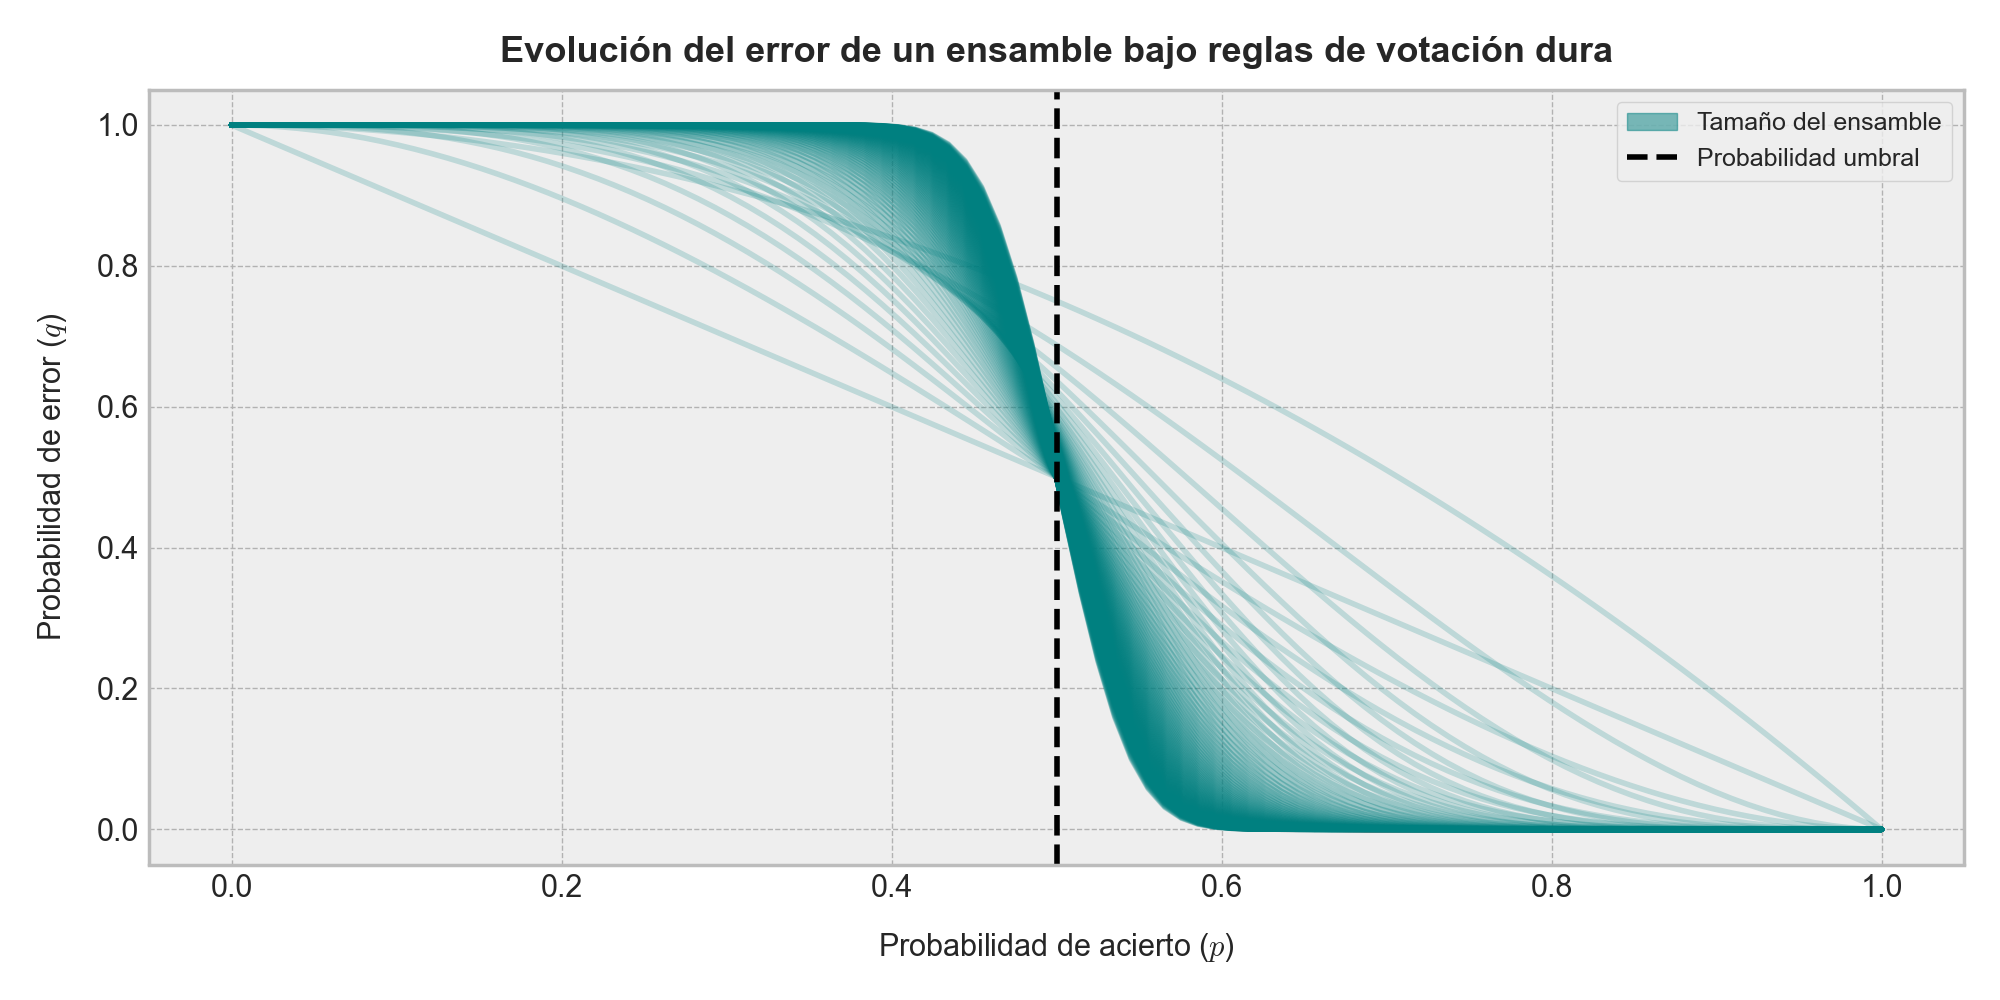

In [8]:
# Visualizamos el efecto de incrementar el valor de `p`.
fig, ax = plt.subplots(figsize=(10, 5))

for k in n_estimators:
    errors = [ensemble_error(p, k) for p in p_vals]
    ax.plot(p_vals, errors, color="teal", alpha=0.2)

ax.fill_between(
    x=[0, 0], y1=[0, 0], color="teal", ec="teal", alpha=0.5, 
    label="Tamaño del ensamble",
)
ax.axvline(x=0.5, color='black', linestyle='--', label="Probabilidad umbral")
ax.set_xlabel(r"Probabilidad de acierto ($p$)", fontsize=11, labelpad=10)
ax.set_ylabel(r"Probabilidad de error ($q$)", fontsize=11, labelpad=10)
ax.set_title(
    "Evolución del error de un ensamble bajo reglas de votación dura",
    fontsize=13, fontweight="bold", pad=10,
)
ax.legend(fontsize=9, frameon=True, loc="best")
plt.tight_layout();

Podemos observar que, efectivamente, independiente del tamaño del ensamble, las probabilidades de error siempre decrecen cuando $p$ es mayor que $0.5$ en forma monótona. Y más aún, mientras más grande es el ensamble, más rápido tenderá $q$ a cero. Sin embargo, hay un límite para esto: No podemos disponer de infinitos predictores individuales en el ensamble, ya que ello hará poco práctica cualquier implementación y/o entrenamiento, sobretodo si las componentes del ensamble son modelos de alta complejidad y/o pobre escalamiento con el número de variables.

Prosigamos desarrollando nuestra idea. Un resultado importante que suele ser utilizado para mostrar que un ensamble que cumple con las condiciones previamente establecidas producirá mejores resultados que sus componentes individuales, es el siguiente.

**<font color='indianred'>Teorema 7.1 – Jurado de Condorcet:</font>** *Sea $r$ un número impar y consideremos un conjunto de $r$ juicios u opiniones expertas (que, en la práctica, serán interpretadas a partir de modelos de clasificación). Admitimos que cada uno de los $r$ "jurados" (o modelos individuales) toma una decisión correcta de manera independiente con la misma probabilidad $p$, tal que $p>\frac{1}{2}$. Entonces se cumple que:*

- *La probabilidad de que la mayoría de esos $r$ jurados acierte es mayor que $p$.*
- *Además, dicha probabilidad tiende a $1$ a medida que $p\rightarrow \infty$*. □

Este resultado es famoso en ciencias políticas y sociales, porque muestra por qué un cuerpo colegiado (el cual tiene una constitución equivalente, en términos estadísticos, a un ensamble de modelos de clasificación “independientes y competentes”) puede ser más fiable que cualquiera de sus miembros tomados aisladamente. En algunos cursos famosos de aprendizaje automático, esta regla suele denominarse de formas más "marketeras" (algunas más correctas que otras), como *wisdom of the crowd* o *best in class*.

Extendiendo la idea del teorema (7.1), para un número finito $r$ de modelos de clasificación, podemos distinguir que:

1. Si $p>\frac{1}{2}$, el valor esperado de aciertos del ensamble será $\mathrm{E} \left[ S \right] =rp$, el cual es mayor que $\frac{1}{2}$.
2. Por propiedades de la distribución de Bernoulli, la mayor parte de la masa en su función de probabilidad se concentra alrededor de la media $rp$. Al estar la media por encima de $p/2$, resulta más probable que $S\geq p/2$ que $S< p/2$.

Aplicando el teorema central del límite ([clase 1.5](https://github.com/rquezadac/udd_data_science_lectures/blob/main/PARTE%20I%20-%20Fundamentos%20matem%C3%A1ticos%20elementales/clase_1_5.ipynb)), generando una aproximación normal de $S$ cuando $r$ crece infinitamente, se tendrá que

$$S\sim \mathcal{N} \left( rp,rp\left( 1-p \right) \right)$$
<p style="text-align: right;">$(7.5)$</p>

Por lo tanto, la probabilidad de que $S\leq \frac{1}{2}$ puede calcularse como

$$\begin{array}{lll}\displaystyle P\left( S\geq \frac{p}{2} \right)&=&\displaystyle P\left( \frac{S-pr}{\sqrt{pr\left( 1-pr \right)}} \geq \frac{\frac{r}{2} -pr}{\sqrt{pr\left( 1-pr \right)}} \right)\\ &=&\displaystyle P\left( Z\geq \frac{\frac{r}{2} -pr}{\sqrt{pr\left( 1-pr \right)}} \right)\end{array}$$
<p style="text-align: right;">$(7.6)$</p>

Donde $Z$ es una variable aleatoria Gaussiana (de tipo estándar). Como $p>\frac{1}{2}$, el numerador $\frac{r}{2} -pr$ es negativo, por lo que la probabilidad de que $Z$ sea mayor que un número negativo es mayor que $\frac{1}{2}$ y aumenta con $r$. En consecuencia, la probabilidad de que el ensamble cometa un error tiende a cero cuando $p\rightarrow \infty$, mientras que el error $q$ de cada clasificador individual permanece fija en $1-p$. Aún con valores de $r$ no muy grandes, la reducción del error de clasificación por efecto del ensamble suele ser significativa cuando $p$ se mantiene por encima de $\frac{1}{2}$ y las correlaciones entre los predictores individuales no son muy altas.

En la práctica, los modelos de clasificación individuales no suelen ser estrictamente independientes; a menudo sus errores están correlacionados, porque, en general, nunca dispondremos de más de un conjunto de entrenamiento para entrenar cada modelo individual en cada uno. Sin embargo, si la correlación no es demasiado grande y cada clasificador sigue teniendo probabilidad de acierto $p>\frac{1}{2}$, la regla de votación dura o mayoritaria tiende a seguir mejorando el rendimiento promedio del ensamble, aunque el efecto no será tan drástico como en el caso ideal de independencia perfecta de los modelos individuales.

El resultado anterior es interesante, pero no global, ya que, por lo general, las probabilidades de acierto asociadas a distintos modelos de clasificación no tendrán por qué ser iguales (lo que es razonable, porque ningún modelo es igual a otro). Sin embargo, a grandes rasgos, la idea central de que un ensamble puede mejorar su desempeño promedio frente a sus componentes individuales se mantiene aun cuando cada componente tenga una probabilidad de acierto distinta. Sin embargo, el análisis matemático se vuelve un poco más complejo, pues:

- La probabilidad de que el ensamble no acierte en sus predicciones ya no estará expresada por una distribución de Bernoulli, porque si bien el ensamble guarda cierta equivalencia al caso de un experimento aleatorio con $r$ repeticiones, las probabilidades de éxito $p_{k}$ de cada uno son diferentes. La suma de los aciertos de cada componente seguirá esta vez una **distribución binomial de Poisson**, que es una extensión de la distribución de Bernoulli al caso de experimentos repetidos con probabilidades distintas de éxito cada uno.
- Tomando la misma notación que para el caso anterior, si cada componente individual del ensamble vota una sola vez, la probabilidad de acierto en su predicción del ensamble será

$$P\left( \mathrm{ensamble\  acierta} \right) =P\left( \sum_{k=1}^{r} X_{k}\geq \left\lceil \frac{n}{2} \right\rceil \right)$$
<p style="text-align: right;">$(7.7)$</p>

- Para cada subconjunto de componentes predictoras, las probablidades de acierto se combinan de forma heterogénea, en lugar de ponderarlas por combinatorias.

Aun así, la intuición y el resultado cualitativo son los mismos: **Si la mayoría (o, más formalmente, la media o mediana, dependiendo del número de componentes del ensamble) de los predictores individuales supera el 50% de aciertos y no están fuertemente correlacionados entre sí, la votación tenderá a lograr un desempeño global mejor que el de (al menos) la mayoría de ellos por separado.** Sin embargo, existe una diferencia clave: **Si una de las componentes del ensamble presenta una probabilidad de acierto en sus predicciones cuyo orden de magnitud es significativamente diferente del resto, entonces es probable que el ensamble no supere en calidad a la mejor componente individual**. Aunque, indudablemente, bajo las reglas de votación mayoritaria, será mejor que el promedio (o cualquier agregación) de los clasificadores individuales.

Para demostrar lo anterior, consideremos nuevamente una colección de $r$ variables aleatorias binarias e independientes definidas como en la ecuación (7.1), que describirán el éxito (o fracaso) en las predicciones de cada uno de los predictores del ensamble. Si designamos por $p_{k}$ a la probabilidad de que el $k$-ésimo predictor individual acierte en su predicción, entonces la variable aleatoria que describe la suma de los aciertos del ensamble completo, a saber

$$S=\sum_{k=1}^{r} X_{k}$$
<p style="text-align: right;">$(7.8)$</p>

sigue una distribución binomial de Poisson,

$$P\left( S=s \right) =\sum_{A\subseteq \left\{ 1,...,r \right\} ,|A|=s} \  \prod_{k\in A} p_{k}\  \prod_{l\notin A} \left( 1-p_{l} \right)$$
<p style="text-align: right;">$(7.9)$</p>

Donde $X_{k}$ es una variable aleatoria con distribución de Bernoulli para todo $k=1,...,r$ y $A$ representa un subconjunto (de tamaño $s$) del juego de índices $\left\{ 1,...,r \right\}$.

En general, no existe una expresión algebraicamente cerrada tan sencilla como en el caso binomial (donde todos los $p_{k}$ son iguales) para expresar la probabilidad asociada a la suma de aciertos $S$ del ensamble, pero sí se conocen procedimientos para calcular o aproximar esta probabilidad.

Sobre la base de la estrategia de votación mayoritaria, la probabilidad de que el ensamble acierte en su predicción será

$$P\left( S\geq \left\lceil \frac{n}{2} \right\rceil \right) =\sum_{k=\left\lceil n/2 \right\rceil}^{r} \  \sum_{A\subseteq \left\{ 1,...,r \right\} ,|A|=s} \  \prod_{k\in A} p_{k}\  \prod_{l\notin A} \left( 1-p_{l} \right)$$
<p style="text-align: right;">$(7.10)$</p>

La suma doble sobre productos dobles anterior no es en absouto sencilla de simplificar, por lo que, en estos casos, solemos recurrir a algoritmos adecuados para resolver este tipo de expresiones. Sin embargo, aunque ya no sea tan directo, bajo los mismos supuestos esenciales de antes ($p_{k}\geq \frac{1}{2}$ para todo $k=1,...,r$ y que los errores cometidos por los predictores individuales no estén fuertemente correlacionados), podemos demostrar que, bajo las reglas de votación mayoritaria, el ensamble presentará una probabilidad de acierto global superior a la de la mayor parte de los clasificadores individuales (pero no a cualquiera de ellos, ya que ésto exigirá que las probabilidades de cada componente del ensamble sean muy similares).

En otras palabras, la probabilidad promedio de que la mayoría acierte es mayor que 0.5 y, a medida que el número de clasificadores crece, esa probabilidad de acierto del ensamble puede acercarse a 1 (siguiendo la idea del teorema (7.1), extendido a probabilidades heterogéneas).

**Ejemplo 7.1 – Una comprobación "a mano":** Consideremos tres modelos de clasificación con probabilidades de acierto en sus predicciones iguales a $p_{1}=0.7,p_{2}=0.7,p_{3}=0.6$, todos ellos independientes (no correlacionados) entre sí. Denotemos como $X_{k}$ a la variable aleatoria que describe si el modelo $k$ acierta ($k=1,2,3$), conforme la ecuación (7.1). De esta manera, $p_{k}=P(X_{k}=1)$. Sea $S=X_{1}+X_{2}+X_{3}$ la variable aleatoria que describe el número de modelos que aciertan en su predicciones. Si construimos un ensamble con estos modelos, entonces la probabilidad de que éste acierte en una predicción será

$$P\left( S\geq 2 \right) =P\left( S=2 \right) +P\left( S=3 \right)$$
<p style="text-align: right;">$(7.11)$</p>

Si dos de los clasificadores aciertan, entonces existen tres formas de que el ensamble acierte en su predicción:

- $X_{1}=1 \wedge X_{2}=1 \wedge X_{3}=0$.
- $X_{1}=1 \wedge X_{2}=0 \wedge X_{3}=0$.
- $X_{1}=0 \wedge X_{2}=1 \wedge X_{3}=1$.

Bajo el supuesto de independencia de estos modelos individuales, tenemos que

$$\begin{array}{lll}P\left( X_{1}=1\wedge X_{2}=1\wedge X_{3}=0 \right)&=&p_{1}p_{2}\left( 1-p_{3} \right)\\ P\left( X_{1}=1\wedge X_{2}=0\wedge X_{3}=1 \right)&=&p_{1}p_{3}\left( 1-p_{2} \right)\\ P\left( X_{1}=0\wedge X_{2}=1\wedge X_{3}=1 \right)&=&p_{2}p_{3}\left( 1-p_{1} \right)\end{array}$$
<p style="text-align: right;">$(7.12)$</p>

Por lo tanto, sumando estas probabilidades, obtenemos

$$P\left( S=2 \right) =p_{1}p_{2}\left( 1-p_{3} \right) +p_{1}p_{3}\left( 1-p_{2} \right) +p_{2}p_{3}\left( 1-p_{1} \right)$$
<p style="text-align: right;">$(7.13)$</p>

Por otro lado, si los tres clasificadores aciertan, habrá una única forma en la cual el ensamble acierte en su predicción, y será cuando $X_{1}=1\wedge X_{2}=1\wedge X_{3}=1$. Si los modelos individuales son independientes, entonces $P(S=3)= P(X_{1}=1\wedge X_{2}=1\wedge X_{3}=1) =p_{1}p_{2}p_{3}$. Por lo tanto, a partir de estos resultados, la probabilidad de que el ensamble acierte en sus predicciones será

$$P\left( S\geq 2 \right) =\underbrace{p_{1}p_{2}\left( 1-p_{3} \right) +p_{1}p_{3}\left( 1-p_{2} \right) +p_{2}p_{3}\left( 1-p_{1} \right)}_{=\mathrm{Exactamente\  dos\  clasificadores\  aciertan}} +\underbrace{p_{1}p_{2}p_{3}}_{=\mathrm{Tres\  clasificadores\  aciertan}}$$
<p style="text-align: right;">$(7.14)$</p>

Reemplazando los valores numéricos de las probabilidades individuales, tenemos:

$$\begin{array}{lllll}p_{1}p_{2}\left( 1-p_{3} \right)&=&0.7\cdot 0.7\cdot \left( 1-0.6 \right)&=&0.196\\ p_{1}p_{3}\left( 1-p_{2} \right)&=&0.7\cdot 0.6\cdot \left( 1-0.7 \right)&=&0.126\\ p_{2}p_{3}\left( 1-p_{1} \right)&=&0.7\cdot 0.6\cdot \left( 1-0.7 \right)&=&0.126\\ p_{1}p_{2}p_{3}&=&0.7\cdot 0.7\cdot 0.6&=&0.294\end{array}$$
<p style="text-align: right;">$(7.15)$</p>

De esta manera,

$$P\left( S\geq 2 \right) =0.196+0.126+0.126+0.294=0.742$$
<p style="text-align: right;">$(7.16)$</p>

Por lo tanto, un ensamble construido a partir de tres modelos de clasificación con probabilidades de acierto en sus predicciones iguales a $p_{1}=0.7,p_{2}=0.7,p_{3}=0.6$, bajo reglas de votación mayoritaria, tendrá una probabilidad de acierto en sus predicciones igual a $0.742$, bajo el supuesto de que tales clasificadores sean estadísticamente independientes. En este caso particular, el ensamble tiene un desempeño mejor que sus componentes individuales, lo que es razonable puesto que las probabilidades de acierto en sus componentes individuales son similares entre sí.

¿Y qué pasaría si las diferencias entre las probabilidades aumentan? Si un clasificador individual se desempeña mucho mejor que el resto, la probabilidad de acierto del ensamble podrá subir, pero en menor proporción, siendo difícil establecer a priori si su desempeño será mejor que cualquier componente individual (aunque se mantendrá mejor que cualquier agregación de estas probabilidades). Por ejemplo, poniendo $p_{2}=0.8$, obtendremos

$$\begin{array}{lllll}p_{1}p_{2}\left( 1-p_{3} \right)&=&0.7\cdot 0.8\cdot \left( 1-0.6 \right)&=&0.224\\ p_{1}p_{3}\left( 1-p_{2} \right)&=&0.7\cdot 0.6\cdot \left( 1-0.8 \right)&=&0.084\\ p_{2}p_{3}\left( 1-p_{1} \right)&=&0.8\cdot 0.6\cdot \left( 1-0.7 \right)&=&0.144\\ p_{1}p_{2}p_{3}&=&0.7\cdot 0.8\cdot 0.6&=&0.336\end{array}$$
<p style="text-align: right;">$(7.17)$</p>

Así que la nueva probabilidad de acierto del ensamble será

$$P\left( S\geq 2 \right) =0.224+0.084+0.144+0.336=0.788$$
<p style="text-align: right;">$(7.18)$</p>

Por lo tanto, $p_{1}=0.7,p_{2}=0.8,p_{3}=0.6$, bajo reglas de votación mayoritaria, el ensamble resultante tendrá una probabilidad de acierto en sus predicciones igual a $0.788$. De esta manera, el ensamble supera a los clasificadores $1$ y $3$ en su desempeño, pero no al $2$ que es el mejor de ellos. Esto pone de manifiesto que el voto mayoritario no necesariamente supera al mejor clasificador individual cuando sus probabilidades de acierto son diferentes entre sí (aunque mayores a $0.5$), pero sí tiende a mejorar el desempeño general en términos de cualquier agregación de esas probabilidades (por ejemplo, $0.788$ es mejor que el promedio de los tres clasificadores, que es $0.7$). ◼︎

**Ejemplo 7.2 – Implementación de un ensamble por votación dura en <font color='mediumorchid'>Scikit-Learn</font>:** En esta sección no construiremos implementaciones desde cero de ningún tipo de ensamble, puesto que sus bases serán modelos que ya hemos desarrollado en profundidad en secciones anteriores, siendo la diferencia entre éstos la forma en la cual agregamos y/o contabilizamos las correspondientes predicciones individuales. Por esta razón, iremos de lleno a ilustrar nuestros casos de uso mostrando las correspondientes implementaciones en **<font color='mediumorchid'>Scikit-Learn</font>**. 

Las herramientas y modelos basados en ensambles se encuentran todos en el módulo `sklearn.ensemble`. Los ensambles de clasificación basados en reglas de votación pueden implementarse por medio de la clase `VotingClassifier`, la cual acepta –entre otros– los siguientes argumentos:

- `estimators`: Corresponde a una lista (de tamaño `n_estimators`) que comprende todos los estimadores de (o compatibles con) **<font color='mediumorchid'>Scikit-Learn</font>** que comprenderán nuestro ensamble. Estos estimadores pueden ser incluso pipelines preconfiguradas. Cada estimador puede especificarse como una tupla en la cual el primer elemento será el nombre corto con el "bautizamos" a dicho estiamdor, siguiendo el mismo estilo de definición de las pipelines de **<font color='mediumorchid'>Scikit-Learn</font>** creadas por medio de la clase `Pipeline`.
- `voting`: String que establece la estrategia de votación del ensamble. Poniendo `voting="hard"` podremos definir una estrategia de votación mayoritaria o dura. También podemos setear este parámetro en `voting="soft"`, lo que establecerá una **estrategia de votación proporcional o "blanda"**. Tal estrategia permite definir ponderadores a gusto para cada una de los predictores individuales del ensamble, típicamente basándonos en su desempeño. Para ello, debemos especificar tales pesos por medio del parámetro `weights`, en un formato de arreglo con la misma dimensión que el número de estimadores a usar para construir el ensamble.
- `weights`: Arreglo de tamaño `n_estimators` que especifica los pesos asociados a cada predictor individual de nuestro ensamble. Sólo es válido su uso al usar una estrategia de votación proporcional (`voting="soft"`). Si no se especifica tal arreglo, **<font color='mediumorchid'>Scikit-Learn</font>** definirá uno "tras bambalinas" con pesos uniformes de acuerdo al desempeño de cada estimadot individual.

En este ejercicio, ejemplificaremos el uso de un ensamble de clasificación bajo reglas de votación mayoritaria. Para ello, haremos uso, como tantas otras veces, del toyset **<font color='forestgreen'>MOONS</font>** para testear nuestros resultados. El ensamble estará compuesto por un total de tres modelos ya conocidos de secciones anteriores: Un modelo de regresión logística binaria, una máquina de soporte vectorial (con kernel de base radial) y un modelo de árbol de decisión. Generaremos un dataset con un nivel significativo de ruido, de manera tal que sea muy difícil alcanzar con estos modelos una exactitud del 100% en las correspondientes predicciones:

In [9]:
import pandas as pd

In [10]:
from sklearn.datasets import make_moons
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score, train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [11]:
# Creamos nuestro conjunto de datos.
X, y = make_moons(n_samples=800, noise=0.5, random_state=42)

In [12]:
# Separamos en datos de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Notemos que, en este ejercicio, no se cumple necesariamente que los clasificadores individuales que hemos instanciado sean estadísticamente independientes, ya que éstos serán entrenados en el mismo conjunto de entrenamiento. Intentaremos mitigar esto generando un proceso de validación cruzada y entregando, en cada subconjunto de validación, la exactitud lograda por este modelo, a fin de poder contar con desempeños agregados. Esto no hará que los predictores individuales del ensamble dejen de estar correlacionados, pero sí permitirá reducir un poco ese efecto en el resultado final:

In [13]:
# Instanciamos algunos modelos por separado en este conjunto de datos.
model_log = Pipeline([
    ("scaler", StandardScaler()), 
    (
        "estimator", 
        LogisticRegression(
            penalty="elasticnet",
            solver="saga",  
            l1_ratio=0.5,
        ),
    ),
])
model_svm = Pipeline([
    ("scaler", StandardScaler()), 
    ("estimator", SVC(kernel="rbf", random_state=42)),
])
model_tree = DecisionTreeClassifier(max_depth=4, random_state=42)

In [14]:
# Evaluamos la calidad de estos modelos por separado.
acc_log_train = cross_val_score(model_log, X_train, y_train, scoring='accuracy', cv=5)
acc_svm_train = cross_val_score(model_svm, X_train, y_train, scoring='accuracy', cv=5)
acc_tree_train = cross_val_score(model_tree, X_train, y_train, scoring='accuracy', cv=5)

In [15]:
# E imprimimos en pantalla estos valores.
print(
    "Exactitud del modelo de regresión logística binaria = {acc}"
    .format(acc=np.mean(acc_log_train).round(3))
)
print(
    "Exactitud del modelo SVM = {acc}"
    .format(acc=np.mean(acc_svm_train).round(3))
)
print(
    "Exactitud del modelo de árbol de decisión = {acc}"
    .format(acc=np.mean(acc_tree_train).round(3))
)
print(
    "Exactitud promedio de todos los modelos = {acc}"
    .format(
        acc=np.column_stack(
            [acc_log_train, acc_svm_train, acc_tree_train]
        )
        .mean(axis=1)
        .mean(axis=0)
        .round(3),
    ),
)

Exactitud del modelo de regresión logística binaria = 0.806
Exactitud del modelo SVM = 0.817
Exactitud del modelo de árbol de decisión = 0.803
Exactitud promedio de todos los modelos = 0.809


Los tres modelos tienen desempeños muy similares. Ahora construimos nuestro ensamble:

In [16]:
# Construimos nuestro ensamble por votación dura.
voting_ensemble = VotingClassifier(
    estimators=[
        ("logistic_reg", model_log), 
        ("svc", model_svm), 
        ("decision_tree", model_tree),
    ], 
    voting="hard",
)

In [17]:
# Evaluamos la exactitud del ensamble.
acc_voting_train = cross_val_score(voting_ensemble, X_train, y_train, scoring='accuracy', cv=5)

In [18]:
# Imprimimos el resultado en pantalla.
print("Exactitud del modelo de árbol de decisión = {acc}".format(acc=np.mean(acc_voting_train).round(3)))

Exactitud del modelo de árbol de decisión = 0.819


Podemos observar que, según los cálculos anteriores, el ensamble tuvo un mejor desempeño que sus componentes individuales durante el proceso de validación cruzada, aunque la diferencia es poco significativa, sobretodo comparada al modelo SVM con kernel de base radial. Podemos comprobar que tales diferencias no son enormes al graficar estos resultados:

In [19]:
# Llevamos las exactitudes a un DataFrame.
accuracies = pd.DataFrame(
    data=np.column_stack(
        [acc_log_train, acc_svm_train, acc_tree_train, acc_voting_train],
    ),
    index=[f"Fold {k + 1}" for k in range(len(acc_log_train))],
    columns=[
        "Regresión Logística\nBinaria", "SVM (kernel de\nbase radial)", 
        "Árbol de\nclasificación", "Ensamble por\nvotación mayoritaria",
    ],
)

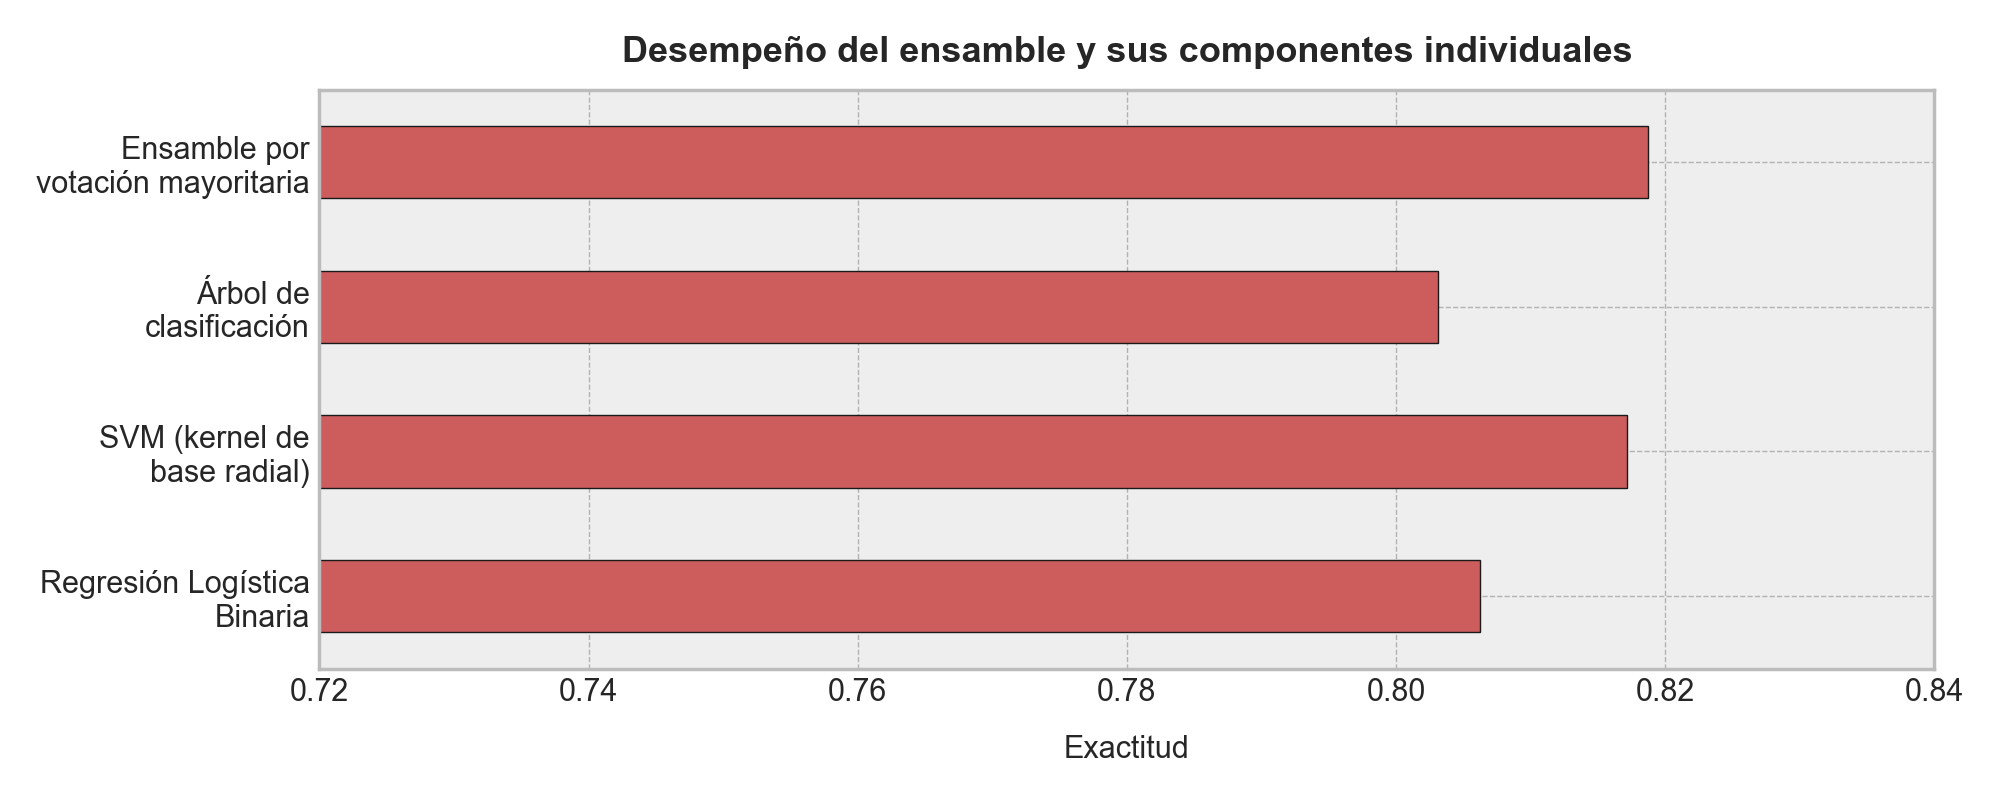

In [20]:
# Comparamos el rendimiento de todos modelos.
fig, ax = plt.subplots(figsize=(10, 4))
accuracies.mean(axis=0).plot(kind="barh", color="indianred", ec="k", lw=0.5, ax=ax)
ax.set_xlim(0.72, 0.84)
ax.set_xlabel("Exactitud", fontsize=11, labelpad=10)
ax.set_title(
    "Desempeño del ensamble y sus componentes individuales", fontweight="bold", 
    fontsize=13, pad=10,
)
plt.tight_layout();

El gráfico anterior comprueba que, efectivamente, el ensamble se dempeña ligeramente mejor que sus componentes individuales, con una exactitud mayor que el promedio de las exactitudes de cada predictor. La diferencia en desempeño es muy pequeña, lo que puede deberse al hecho de que las componentes del ensamble están correlacionadas entre sí al haber sido entrenadas sobre el mismo conjunto de datos, incluso después de intentar mitigar este efecto por medio de un procedimiento de validación cruzada. ◼︎

### Ensambles por votación para problemas de regresión.
A diferencia de lo que ocurre en los problemas de clasificación, donde los ensambles sueñen definirse bajo una regla de votación mayoritaria o dura, en el caso de los **problemas de regresión** un ensamble suele combinar las salidas (que, en esta oportunidad, se trata de predicciones continuas) de los distintos modelos de forma agregada (por ejemplo, tomando el promedio, la mediana u otra estadística robusta). Sin embargo, la lógica subyacente es muy similar: Combinar predicciones independientes y “razonablemente buenas” tiende a producir un mejor desempeño global respecto del desempeño de tales predicciones individuales.

Supongamos que tenemos $r$ modelos de regresión (de nuevo, tales modelos pueden ser de cualquier tipo e, incluso, juicios u opiniones expertas), cada uno de los cuales se ha entrenado para estimar una variable de salida $\mathbf{y}\in \mathbb{R}^{m}$ a partir de una matriz de diseño $\mathbf{X}\in \mathbb{R}^{m\times n}$. El $k$-ésimo modelo ($k=1,...,r$) genera una predicción $\hat{\mathbf{y}}_{k}$. Supongamos que:

- **(S1):** Cada predictor, digamos $\hat{\mathbf{y}}_{k}$ para cada $k=1,...,r$ es (en promedio) **no sesgado** respecto de $\mathbf{y}$. Matemáticamente, esto implica que asumiremos que $\mathrm{E}[\hat{\mathbf{y}}_{k}]=\mathbf{y}$ para cada $k$ o, equivalentemente, $\mathrm{E}[\hat{\mathbf{y}}_{k}- \mathbf{y}]=0$.
- **(S2):** Las desviaciones de cada predictor (ruido o, en términos prácticos, el error que éstos cometen) no presentan una correlación significativa entre ellas. Matemáticamente, esto equivale a asumir que $\mathrm{Cov} \left( \hat{\mathbf{y}}_{k} -\mathbf{y} ,\hat{\mathbf{y}}_{l} -\mathbf{y} \right) \approx 0$, para $k\neq l$.
- **(S3):** La mayoría de los modelos (ojalá, todos ellos) presentan una cierta calidad o desempeño mínimo esperado. En este caso puntual, no existe un equivalente a la condición $p>\frac{1}{2}$ que establecimos para los ensambles de clasificación, porque no tiene sentido hablar de "probabilidades" de acierto para los modelos individuales, ya que si las salidas son continuas, en general, no estaremos interesados en que nuestros modelos se ajusten de manera exacta a ellas (de hecho, lo más probable es que, si esto ocurre, estemos en presencia de un caso de overfitting). En problemas de regresión, comunmente, estamos interesados en minimizar el error $\hat{\mathbf{y}}_{k} -\mathbf{y}$, tolerando ciertas diferencias en ambos sentidos (positivo y negativo).

Queremos comprobar que las condiciones anteriores permiten que todo ensamble construido a partir de los $r$ modelos reducirá la varianza del error con respecto a los predictores individuales, lo que en términos prácticos mejorará la calidad de las predicciones globales (aumentará la "precisión" del modelo resultante). Sea pues $E_{k}=\hat{\mathbf{y}}_{k} -\mathbf{y}$ el error cometido por el $k$-ésimo predictor individual del ensamble. Por (S1), se tendrá que $\mathrm{E}[E_{k}]=0$ para cada $k=1,...,r$. Por lo tanto, el error cometido por el ensamble (promediado) será

$$\begin{array}{lll}E_{\mathrm{ensamble}}&=&\hat{\mathbf{y}}_{\mathrm{ensamble}} -\mathbf{y}\\ &=&\displaystyle \frac{1}{r} \sum_{k=1}^{r} \left( \hat{\mathbf{y}}_{k} -\mathbf{y} \right)\\ &=&\displaystyle \frac{1}{r} \sum_{k=1}^{r} E_{k}\end{array}$$
<p style="text-align: right;">$(7.19)$</p>

Si los predictores individuales son estadísticamente independientes, por (S2), tendremos que

$$\begin{array}{lll}\mathrm{Var} \left( E_{\mathrm{ensamble}} \right)&=&\displaystyle \mathrm{Var} \left( \frac{1}{r} \sum_{k=1}^{r} E_{k} \right)\\ &=&\displaystyle \frac{1}{r^{2}} \mathrm{Var} \left( \sum_{k=1}^{r} E_{k} \right)\\ &=&\displaystyle \frac{1}{r^{2}} \sum_{k=1}^{r} \mathrm{Var} \left( E_{i} \right)\end{array}$$
<p style="text-align: right;">$(7.20)$</p>

Donde hemos asumido que $\mathrm{Var} \left( \sum_{k=1}^{r} E_{k} \right) =\mathrm{Var} \left( E_{i} \right)$ debido a que, por (S2), las covarianzas entre los errores de cada predictor individual son despreciables. Supongamos que todos los predictores tienen la misma varianza del error $\sigma^{2}$ (lo que es razonable, puesto que, por (S3), hemos pedido que todos los modelos tengan calidades "similares"). De esta manera,

$$\mathrm{Var} \left( E_{\mathrm{ensamble}} \right) =\frac{\sigma^{2}}{r}$$
<p style="text-align: right;">$(7.21)$</p>

Por lo tanto, podemos concluir que un ensamble construido a partir de $r$ modelos no sesgados, estadísticamente independientes y con la misma varianza $\sigma^{2}$ de sus errores, reduce la varianza de tales errores en un factor de $1/r$. De esta manera, el promedio de las predicciones individuales reduce la varianza de la estimación del ensamble (bajo las condiciones previamente descritas), gracias a que las desviaciones aleatorias de unos se compensan con las de otros. Es decir, **cada modelo individual compensa las debilidades de los otros**.

En la práctica, los modelos no suelen ser perfectamente independientes, porque será muy raro que dispongamos de más de un conjunto de entrenamiento. Entrenar varios modelos en el mismo conjunto de datos inducirá un nivel variable de correlación entre los errores de cada uno. Si hay correlaciones positivas entre los errores, la varianza se reduce menos, ya que

$$\mathrm{Var} \left( \sum_{k=1}^{r} E_{k} \right) =\sum_{k=1}^{r} \mathrm{Var} \left( E_{k} \right) +2\underset{k\neq l}{\sum_{k=1}^{r} \sum_{l=1}^{r}} \mathrm{Cov} \left( E_{k},E_{l} \right)$$
<p style="text-align: right;">$(7.22)$</p>

El término de covarianza puede ser significativo, reduciendo el beneficio total de la constitución del ensamble completo. Sin embargo, mientras la correlación entre los errores no sea demasiado fuerte, el ensamble por promedio conserva una parte de la ventaja de “compensar” los errores individuales de cada componente.

**Ejemplo 7.3 – Un caso de estudio relativo al modelamiento del rendimiento de un circuito de molienda SAG:** A continuación abordaremos un caso de estudio relativo a la predicción del rendimiento de un molino SAG en una planta concentradora. Existen varias razones sustentadas en el negocio que motivan la resolución de un problema de este tipo: Podríamos disponer de un modelo (no necesariamente sencillo) que nos permita simular escenarios en el corto plazo para condiciones más o menos exigentes en la operación de la planta. También podríamos querer utilizar un modelo como función objetivo de una rutina de optimización que nos permita disponer de un vector óptimo de variables de control en el contexto de un **sistema de analítica prescriptiva**. Sea como sea, un modelo que puede estimar el tratamiento de un molino SAG a partir de variables operacionales, contextuales y de control en una planta puede ser un activo especialmente valioso.

En este ejemplo, construiremos un ensamble por votación apto para modelos de regresión, y que usaremos para predecir el tratamiento de un molino SAG inmerso en un circuito completo. Para ello, haremos uso del conjunto de datos almacenado en el archivo `sag_mill_data.csv` y haremos las importaciones necesarias:

In [21]:
from scipy.stats import loguniform, randint, uniform, zscore
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import VotingRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [22]:
# Accedemos a nuestro conjunto de datos.
df = pd.read_csv("datasets/sag_mill_data.csv")

Inspeccionaremos las primeras filas y las columnas de este DataFrame:

In [23]:
# Verificamos las primeras filas de este DataFrame.
df.head()

fecha  veloc_fe01  veloc_fe02  veloc_fe03  veloc_sag1  \
0  2019-10-10 01:00:00   44.002292   61.697014   43.076181   10.247453   
1  2019-10-10 05:00:00   49.861042   68.718611   49.421667   10.447173   
2  2019-10-10 09:00:00   48.565833   57.258542   43.385278    7.900278   
3  2019-10-10 17:00:00   41.989167   90.112014    6.754861   10.357497   
4  2019-10-10 21:00:00   49.610208   93.412500   22.173681   10.505795   

   veloc_fe_aux_04  nivel_cuba     pot_sag1     pot_bm1a      pot_bm1b  ...  \
0         0.000000   66.348738  3393.294026  3421.604785  11495.049503  ...   
1         0.000000   58.547041  3540.129670  3505.969786  11935.476313  ...   
2         0.000000   62.420050  3367.213297  2954.179433  11675.420949  ...   
3         9.024211   70.039374  3458.648343  3139.762935   9446.040584  ...   
4         0.000000   68.700279  3461.964419  3486.432077  12576.026435  ...   

   veloc_relat_fe02  veloc_relat_fe03  niv_tolva_repart  \
0         41.176471         29.411765         63.434975   
1         40.519955         29.740023         62.545132   
2         38.354470         26.678008         61.361484   
3         61.424617          3.434870         59.974412   
4         58.823529         11.764706         54.031178   

   cee_real_4h_atras_sag1   calc_jb   calc_jc  prop_min_fuente_a  \
0                0.003643  0.153678  0.277600                NaN   
1                0.003972  0.152895  0.275716                NaN   
2                0.003452  0.152895  0.248393                NaN   
3                0.004408  0.150977  0.276203                NaN   
4                0.003863  0.150337  0.275312                NaN   

   prop_min_fuente_b  calc_spi_traz_ios    rend_sag1  
0                NaN                NaN  2067.167834  
1                NaN                NaN  2364.608783  
2                NaN                NaN  1602.291196  
3                NaN                NaN  2077.892590  
4                NaN                NaN  2483.242442  

[5 rows x 41 columns]

In [24]:
# Revisamos rápidamente los tipos de cada columna.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4003 entries, 0 to 4002
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fecha                    4003 non-null   object 
 1   veloc_fe01               3958 non-null   float64
 2   veloc_fe02               3975 non-null   float64
 3   veloc_fe03               3961 non-null   float64
 4   veloc_sag1               4003 non-null   float64
 5   veloc_fe_aux_04          3832 non-null   float64
 6   nivel_cuba               4003 non-null   float64
 7   pot_sag1                 3995 non-null   float64
 8   pot_bm1a                 4002 non-null   float64
 9   pot_bm1b                 4003 non-null   float64
 10  pot_bm3c                 3986 non-null   float64
 11  pres_alim_bhc1a          4002 non-null   float64
 12  pres_alim_bhc1b          4003 non-null   float64
 13  pres_desc_sag1           3937 non-null   float64
 14  pres_bhc3c              

La situación descrita por este conjunto de datos corresponde a la de un proceso de molienda SAG que se alimenta de mineral proveniente de un stock de material intermedio o IOS (*intermediate ore stockpile*), junto con ciertas variables que describen el trasporte de mineral hacia los molinos. La situación general se observa en la Fig. (7.2).

<p style="text-align: center;"><img src="figures/fig_7_3.png" width="1200"></p>
<p style="text-align: center;">Fig. (7.2): Flujograma que ilustra la situación descrita por este ejercicio. Dos circuitos de molienda SAG que trabajan en paralelo se alimentan de mineral proveniente de un stock de mineral intermedio (IOS) mediante un sistema de correas y chutes de alimentación, a partir de una tolva que reparte la carga conforme es necesario. Este sistema de correas contempla la recirculación de pebbles chancados en el proceso, además de la incorporaciónd e un molino de bolas dedicado para la reducción de tamaño de los pebbles que son chancados y que llegan al molino desde los chancadores de pebbles y, además, desde transferencias de carga desde las baterías de hidrociclones</p>

El circuito descrito en la Fig. (7.2) contempla una planta de molienda alimentada desde el IOS, constituido por mineral que ya ha pasado por un proceso de chancado primario. Desde el IOS se alimenta mineral a un sistema de feeders que genera una muestra en función de los niveles de segregación presentes en el stock. El mineral luego es transportado directamente a la alimentación del molino SAG correspondiente, donde su tamaño es reducido significativamente. La descarga del molino SAG es clasificada mediante un sistema de harneros, permitiendo que el sobretamaño sea redirigido a la planta de chancado de pebbles por medio de un sistema de correas. El mineral que pasa por los harneros es descargado en una cuba desde la cual, mediante un sistema de bombas, es impulsado hacia las correspondientes baterías de hidrociclones donde es clasificado nuevamente. El overflow de los ciclones (mineral más fino) va hacia la flotación, que es el proceso posterior, mientras que el underflow (mineral más grueso) se deirige a un proceso de molienda de bolas, cuya descarga vuelve a la cuba a repetir el proceso.

EL circuito de pebbles está constituido por un sistema de correas que alimenta a tres chancadores de pebbles mediante un carro tripper que deposita el mineral en una tolva (denominada BN-002). La descarga de los chancadores va hacia la correa CV-09, desde la cual puede o no existir una recirculación directa de pebbles chancados de vuelta a los molinos SAG por medio de la correa CV-010. Si no hay problemas de disponibilidad de equipos aguas abajo, los pebbles chancados pasan por un proceso de molienda auxiliar (donde el molino se designa como BM-03) previa clasificación, para luego, en el caso del mineral más fino, ser enviado directamente al proceso de flotación.

Notemos que ambos circuitos de clasificación húmeda (post-molienda SAG) generan transferencias de carga desde las baterías de hidrociclones hacia el molino BM-03. Dichas transferencias se realizan desde determinados ciclones en cada batería, pero sólo está documentada su activación por medio de variables binarias, no su cantidad.

El conjunto de datos de interés está constituido por los siguientes campos o variables:

- `fecha`: Corresponde al momento en el tiempo en el cual se observan los datos asociados a la correspondiente fila de esta tabla. Estos valores, conforme la información extraída del DataFrame en la celda de código anterior, viene en un formato `object`, lo que significa que cada valor en esta columna es un string que debe ser transformado en un formato `Timestamp` adecuado para indexar luego este conjunto de datos. Notemos que cada observación corresponde a un muestreo cada 4 horas.
- `veloc_fe01`: Velocidad de movimiento del feeder FE-01 que alimenta al molino SAG 1. Esta velocidad (y la del resto de los feeders) se expresa como un porcentaje, el que representa el nivel de rapidez al que opera la correa. Un 100% indica que la correa está operando a su máxima velocidad.
- `veloc_fe02`: Velocidad de movimiento del feeder FE-02 que alimenta al molino SAG 1.
- `veloc_fe03`: Velocidad de movimiento del feeder FE-03 que alimenta al molino SAG 1.
- `veloc_sag1`: Velocidad de rotación a la que está operando el molino SAG 1, en rpm. Esta variable es muy importante en el control de la molienda, puesto que impacta directamente en el tiempo de residencia del mineral al interior del molino. Suele ser utilizada por la mayoría de los controladores avanzados de procesos (APC, o *advanced  process control*) para generar un control de la presión de carga en los descansos del molino en función de su nivel de llenado y la granulometría de la carga.
- `veloc_fe_aux_04`: Velocidad de feeder de apoyo a la correa alimentadora principal del molino SAG 1.
- `nivel_cuba`: Nivel de llenado de la cuba de descarga del circuito de molienda, expresado como un porcentaje. Un nivel del 100% indica una cuba completamente llena.
- `pot_sag1`: Potencia demandada por el molino SAG 1, en kW.
- `pot_bm1a`: Potencia demandada por el molino de bolas 1A, en kW.
- `pot_bm1b`: Potencia demandada por el molino de bolas 1B, en kW.
- `pot_bm3c`: Potencia demandada por el molino de bolas auxiliar 3C, en MW.
- `pres_alim_bhc1a`: Presión alimentación a la batería de ciclones BHC-1A, en psi.
- `pres_alim_bhc1b`: Presión alimentación a la batería de ciclones BHC-1B, en psi.
- `pres_desc_sag1`: Presión promedio de carga en los descansos del molino SAG 1, en kg/cm$^{2}$. Esta es la variable más importante en el control del estado de salud del molino. Esta presión es mayor al inicio de cada campaña de revestimientos, ya que éstos, al estar completamente nuevos y no haber sufrido desgaste, contribuyen con mayor masa al sistema "mineral + molino", aumentando la presión, ya que el nivel de llenado del molino (mineral + medios de molienda) suele mantenerse lo más constante posible. A medida que la campaña pregresa, esta presión suele caer (muchas veces linealmente) hasta el nuevo cambio de revestimientos, ya que éstos se van desgastando por la abrasión producida por el impacto del mineral debido a la rotación del molino, perdiendo masa y, por tanto, generando disminuciones progresivas en la presión.
- `pres_bhc3c`: Presión de alimentación de la batería de ciclones BHC-3C, en bares.
- `solidos_sag1`: Porcentaje de sólidos en la alimentación del molino SAG 1. Esta es una medida de la densidad de su carga circulante.
- `agua_manual_sag1`: Suma de todos los flujos locales de agua que contribuyen con modificar el porcentaje de sólidos reportado por el sensor (densímetro) que genera los datos de la columna anterior, en m$^{3}$/h. Se trata pues de una medición de ruido inducido por perturbaciones inducidas por la operación.
- `flujo_agua_cuba_bm3c`: Flujo de agua que alimenta a la cuba de descarga del circuito de molienda, m$^{3}$/h.
- `pebbles_gen_sag1`: Flujo másico de pebbles generados por la operación del molino SAG 1, en tph.
- `pebbles_recirc_sag1`: Flujo másico de pebbles chancados recirculados de vuelta hacia el molino SAG 1, en tph.
- `prop_finos_sag1`: Proporción de la alimentación del molino SAG 1 que corresponde a mineral de tamaño fino (tamaño bajo 1"), en %.
- `prop_interm_sag1`: Proporción de la alimentación del molino SAG 1 que corresponde a mineral de tamaño intermedio (tamaño entre 1" y 4"), en %.
- `nivel_stock_ios_sensor1`: Nivel de llenado del stockpile de mineral intermedio que alimenta a la molienda SAG, en %. Este valor corresponde a la medición realizada por un sensor láser ubicado en la "pata" (región inferior) del stockpile.
- `nivel_stock_ios_sensor2`: Nivel de llenado del stockpile de mineral intermedio que alimenta a la molienda SAG, en %. Este valor corresponde a la medición realizada por un sensor láser ubicado en la "cresta" (región superior) del stockpile.
- `nivel_tolva_p1`: Nivel de llenado de la tolva de alimentación del chancador de pebbles CR-01, en %.
- `nivel_tolva_p2`: Nivel de llenado de la tolva de alimentación del chancador de pebbles CR-02, en %.
- `nivel_tolva_p3`: Nivel de llenado de la tolva de alimentación del chancador de pebbles CR-03, en %.
- `status_cy_transf_bhc1a`: Variable binaria que representa el estado de hidrociclón de transferencia de carga a molino BM-03 en batería BHC-01A.
- `status_cy_transf_bhc1b`: Variable binaria que representa el estado de hidrociclón de transferencia de carga a molino BM-03 en batería BHC-01B.
- `status_cy_transf_bhc2a`: Variable binaria que representa el estado de hidrociclón de transferencia de carga a molino BM-03 en batería BHC-02A.
- `veloc_relat_fe01`: Velocidad relativa normalizada del feeder FE-01 con respecto a la suma de los tres feeders, en %.
- `veloc_relat_fe02`: Velocidad relativa normalizada del feeder FE-02 con respecto a la suma de los tres feeders, en %.
- `veloc_relat_fe03`: Velocidad relativa normalizada del feeder FE-03 con respecto a la suma de los tres feeders, en %.
- `niv_tolva_repart`: Nivel de llenado de la tolva repartidora de carga entre ambas líneas de molienda SAG, en %.
- `cee_real_4h_atras_sag1`: Consumo específico de energía del molino SAG 1 estimado cuatro horas atrás, en kWh/t. Observamos que ésta se trata de una variable "lagueada" o "retardada".
- `calc_jb`: Nivel de llenado de bolas del molino SAG 1, en %. Este valor es estimado por medio de un modelo empírico.
- `calc_jc`: Nivel de llenado total (carga + bolas) del molino SAG 1, en %. Este valor es estimado por medio de un modelo empírico.
- `prop_min_fuente_a`: Proporción de mineral en la alimentación de la molienda SAG que proviene desde la mina A, en %.
- `prop_min_fuente_b`: Proporción de mineral en la alimentación de la molienda SAG que proviene desde la mina B, en %.
- `calc_spi_traz_ios`: Estimación de la dureza del mineral conforme el índice de potencia del molino SAG (*SAG power index* o SPI). Se trata de un parámetro adimensional y de naturaleza geometalúrgica cuyo objetivo es estimar el tiempo de residencia necesario para reducir el tamaño del mineral de interés a su tamaño de liberación. Por esta razón, mientras mayor sea la magnitud del SPI, se asume que el mineral es más duro.
- `rend_sag1`: Rendimiento del molino SAG 1, en tph.

Si bien son muchísimas variables (al menos, en una primera lectura), podemos observar que el conjunto de datos mapea completamente lo que ocurre, a nivel de proceso, en la línea de molienda SAG 1, registrando además procesos paralelos (circuito de pebbles) y aguas arriba (sistema de correas). Además, tras inspeccionar las primeras filas del DataFrame, podemos observar que cada fila corresponde a un promedio (o muestreo) de 4 horas de operación en la molienda, con algunos saltos de tiempo, debido –probablemente– a que este conjunto de datos ya fue manipulado previamente.

Partimos formateando la columna `fecha` e indexando el DataFrame completo con respecto a ella:

In [25]:
# Cambiamos la columna de tiempo de este DataFrame a un formato adecuado e indexamos.
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)

De la información obtenida del DataFrame por medio del método `info()`, vemos que existen varias variables con una cantidad significativa de registros vacíos (`NaN`). En esta oportunidad, nos haremos cargo de limpiar tales registros, considerando la generación de un procedimiento muy sencillo que garantice un nivel mínimo de calidad en nuestros datos. Para ello, nos fijaremos en tres aspectos importantes:

- La cantidad de registros vacíos (`NaN`).
- La cantidad de registros con valores nulos (iguales a `0`).
- La cantidad de campos con muy baja (o nula) variabilidad (controlada por la razón entre la desviación estándar de cada variable sobre la media correspondiente).

Generamos primero la cuantía de registros sin datos por variable, y luego la cuantía de ceros por variable:

In [26]:
# Determinamos el promedio de registros vacíos por cada variable (en términos absolutos).
nan_vals = df.isnull().mean()

In [27]:
# Determinamos el promedio de valores nulos en cada variable (en términos absolutos).
zero_vals = (df == 0).mean()

A continuación, determinamos los coeficientes de variación de cada variable dividiendo su correspondiente desviación estándar por la media. Estamos interesados, particularmente, en todas aquellas variables con, al menos, un 5% de variabilidad:

In [28]:
# Determinamos el coeficiente de variación 
low_var_vals = df.std() / df.mean()
low_var_vals[pd.isna(low_var_vals)] = 0 

Con la información calculada previamente, generamos un nuevo DataFrame que contendrá ciertos puntajes asociados a la calidad de los datos por campo. Para ello, escalaremos cada una de las columnas de dicho DataFrame sobre la base del valor máximo encontrado en cada aspecto de calidad:

In [29]:
# Construimos un DataFrame con las métricas de calidad del dataset. Para el caso de la
# varianza, nos preocuparemos mayormente de aquellas variables con variabilidad menor a
# un 5%.
quality_df = pd.DataFrame({
    "Datos faltantes": nan_vals * 100,
    "Valores nulos": zero_vals * 100,
    "Baja variabilidad": (low_var_vals < 0.05) * 100
})

In [30]:
# Normalizamos los valores del DataFrame, para tener una visualización adecuada.
quality_df_normalized = quality_df / quality_df.max()

Y ahora graficamos estos datos en un mapa de calor, a modo de construir una especie de matriz de calidad de datos para este ejercicio:

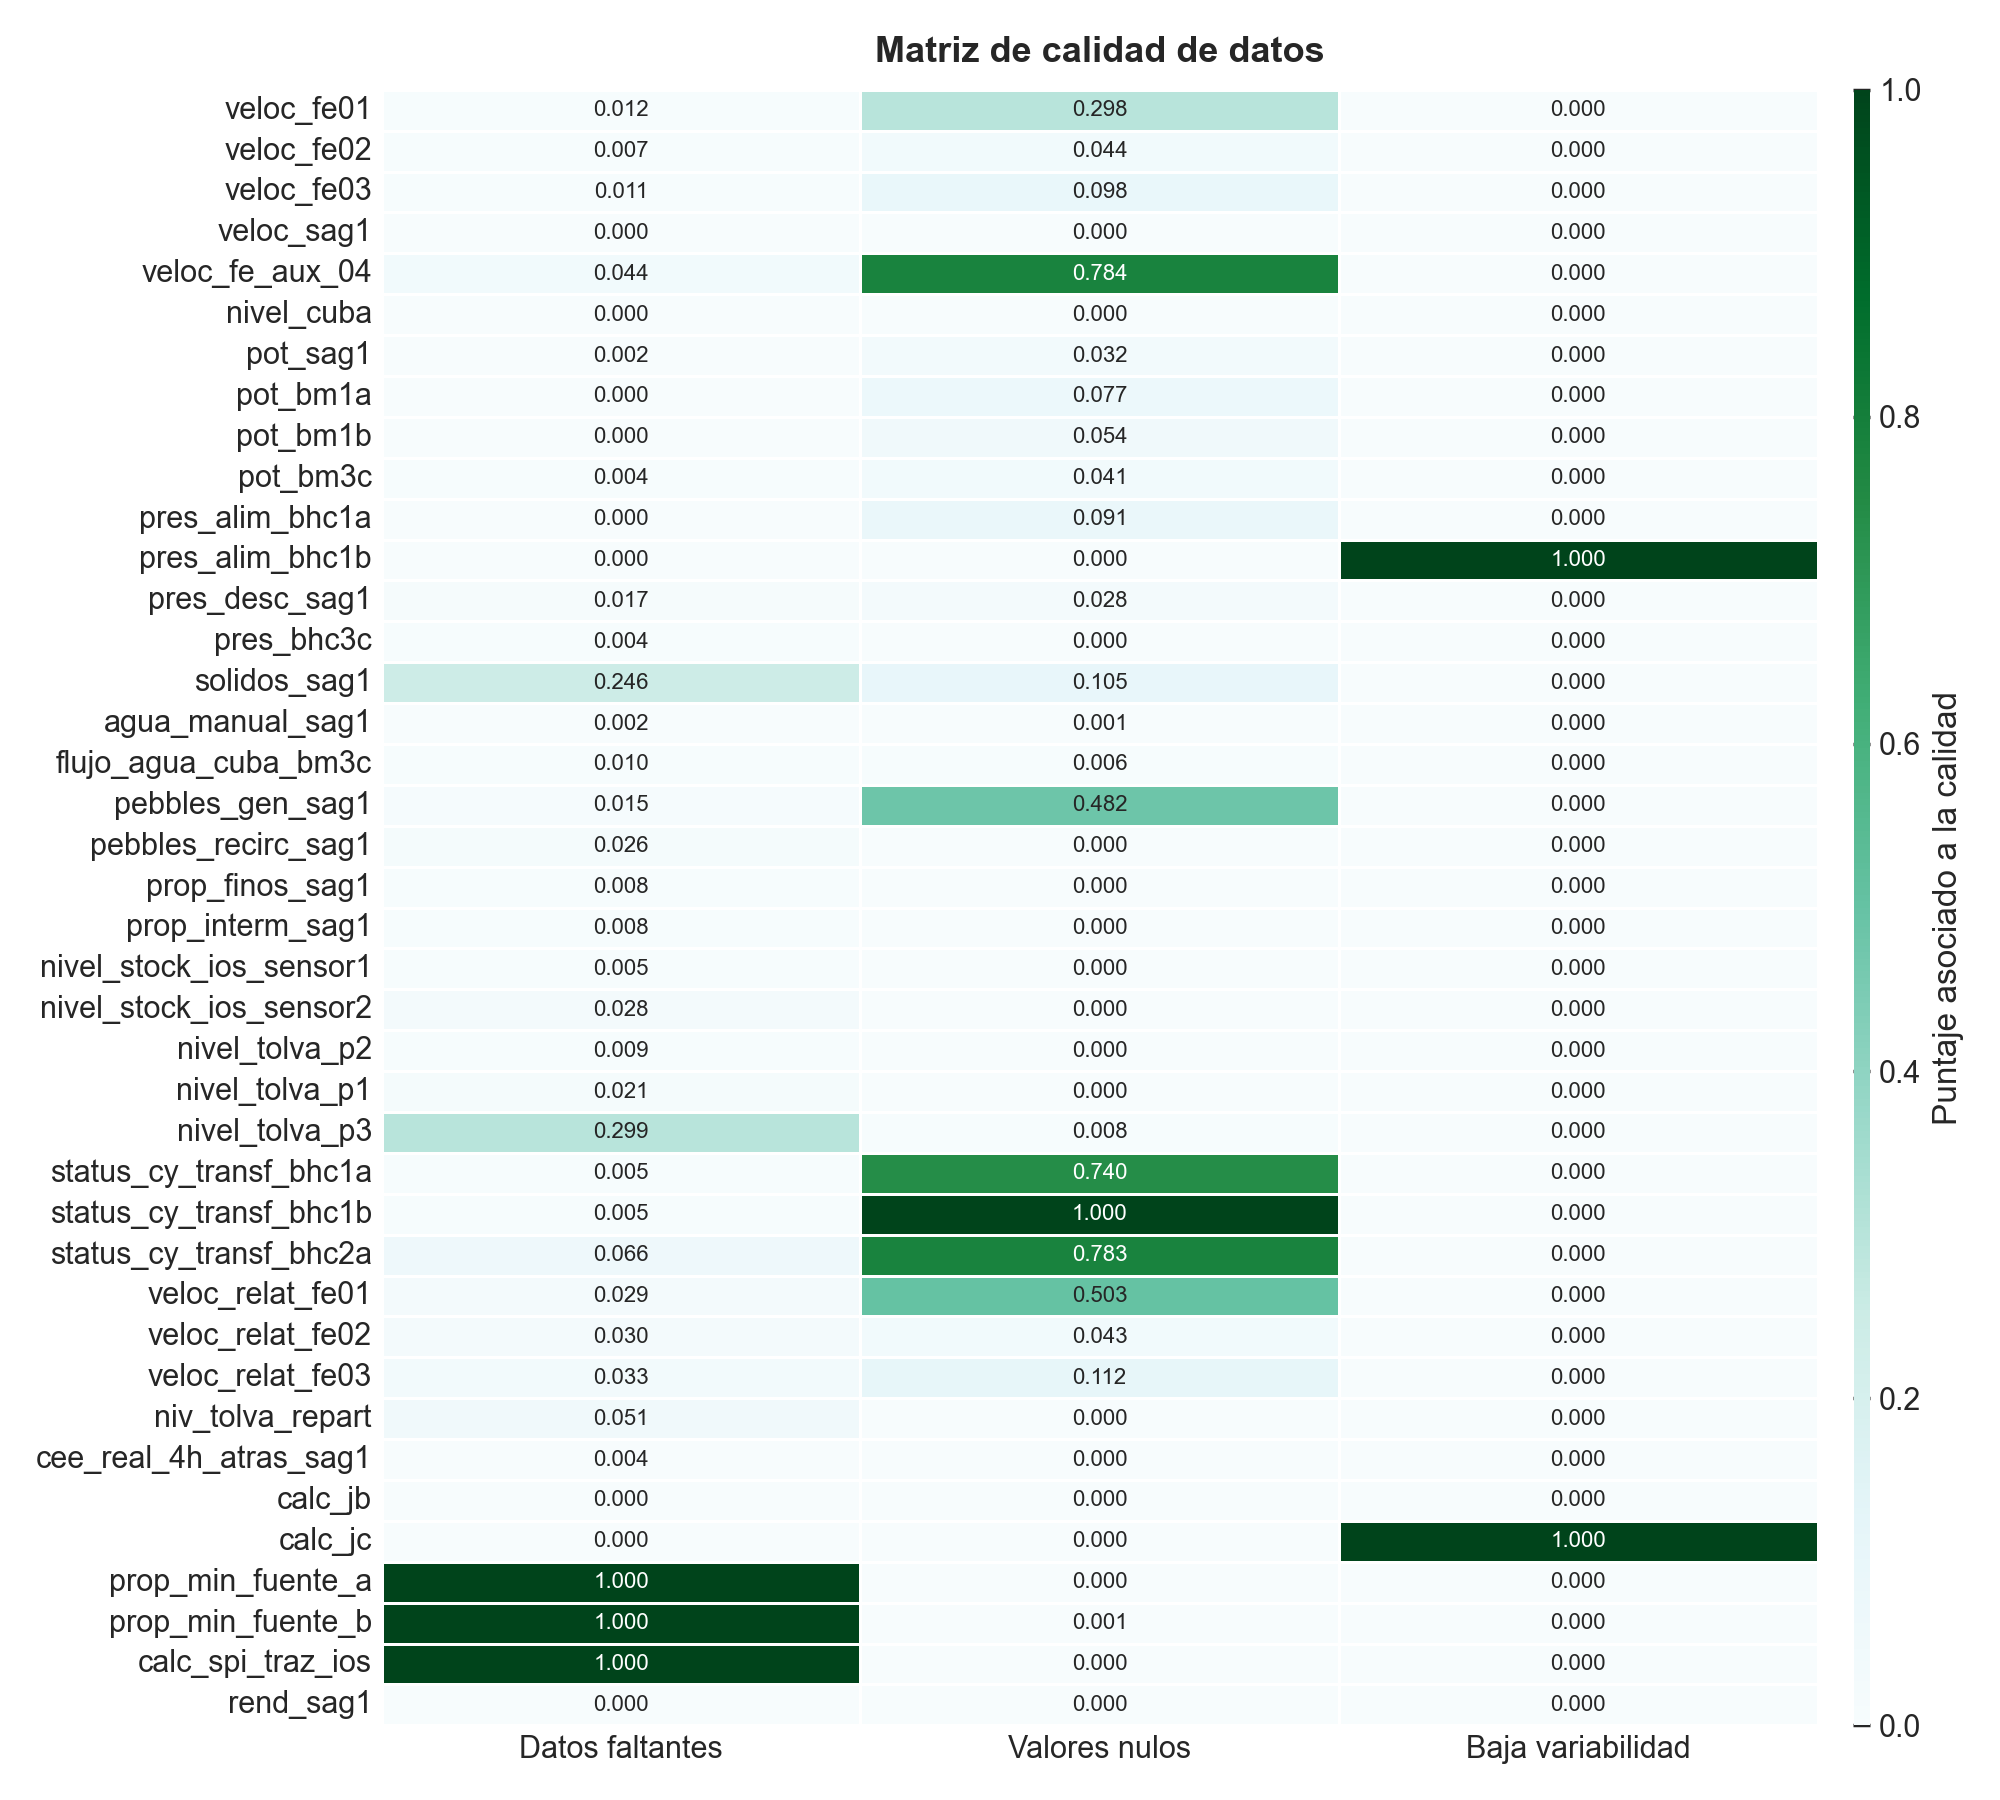

In [31]:
# Generamos un mapa de calor de calidad.
grid_spec = {"width_ratios": (0.90, 0.01)}
f, (ax, cbar_ax) = plt.subplots(
    figsize=(10, 9), nrows=1, ncols=2, gridspec_kw=grid_spec,
)
sns.heatmap(
    quality_df_normalized, cmap="BuGn", annot=True, annot_kws={"fontsize": 8}, 
    fmt=".3f", lw=1.0, ec="w", cbar_kws={"label": "Puntaje asociado a la calidad"}, 
    ax=ax, cbar_ax=cbar_ax,
)
cbar_ax.yaxis.label.set_size(12)
ax.set_title("Matriz de calidad de datos", fontsize=13, fontweight="bold", pad=10)
plt.tight_layout();

Algunas observaciones importantes:

- Las variables `prop_min_fuente_a`, `prop_min_fuente_b` y `calc_spi_traz_ios` son fuertes candidatas a ser descartadas del DataFrame por tener una enorme cantidad de registros sin datos. De hecho, la inspección por el método `info()` las descarta de plano, puesto que sólo poseen `109` valores cada una, contra un promedio de `3900` para el resto de las variables.
- La variable `calc_jc` tamboén es una fuerte candidata a ser descartada, puesto que prácticamente no varía durante todo el tiempo descrito por el conjunto de datos completo.
- Las variables que parten con `status_` no salen del DataFrame, puesto que, al ser binarias, es esperable que contengan muchos datos iguales a cero y, por tanto, tengan un puntaje alto en ese aspecto de calidad.
- La variable `pres_alim_bhc1b` es una fuerte candidata a salir del proceso de entrenamiento, ya que posee una muy baja variabilidad. Sin embargo, esta variable resulta importante, puesto que describe la presión de trabajo de una de las baterías de ciclones del circuito aguas abajo del molino SAG.

Para determinar si, efectivamente, la variable de presión no será elegida para entrenar a nuestro modelo, graficamos su valor junto a la de su batería gemela, a fin de verificar si esto es un problema puntual:

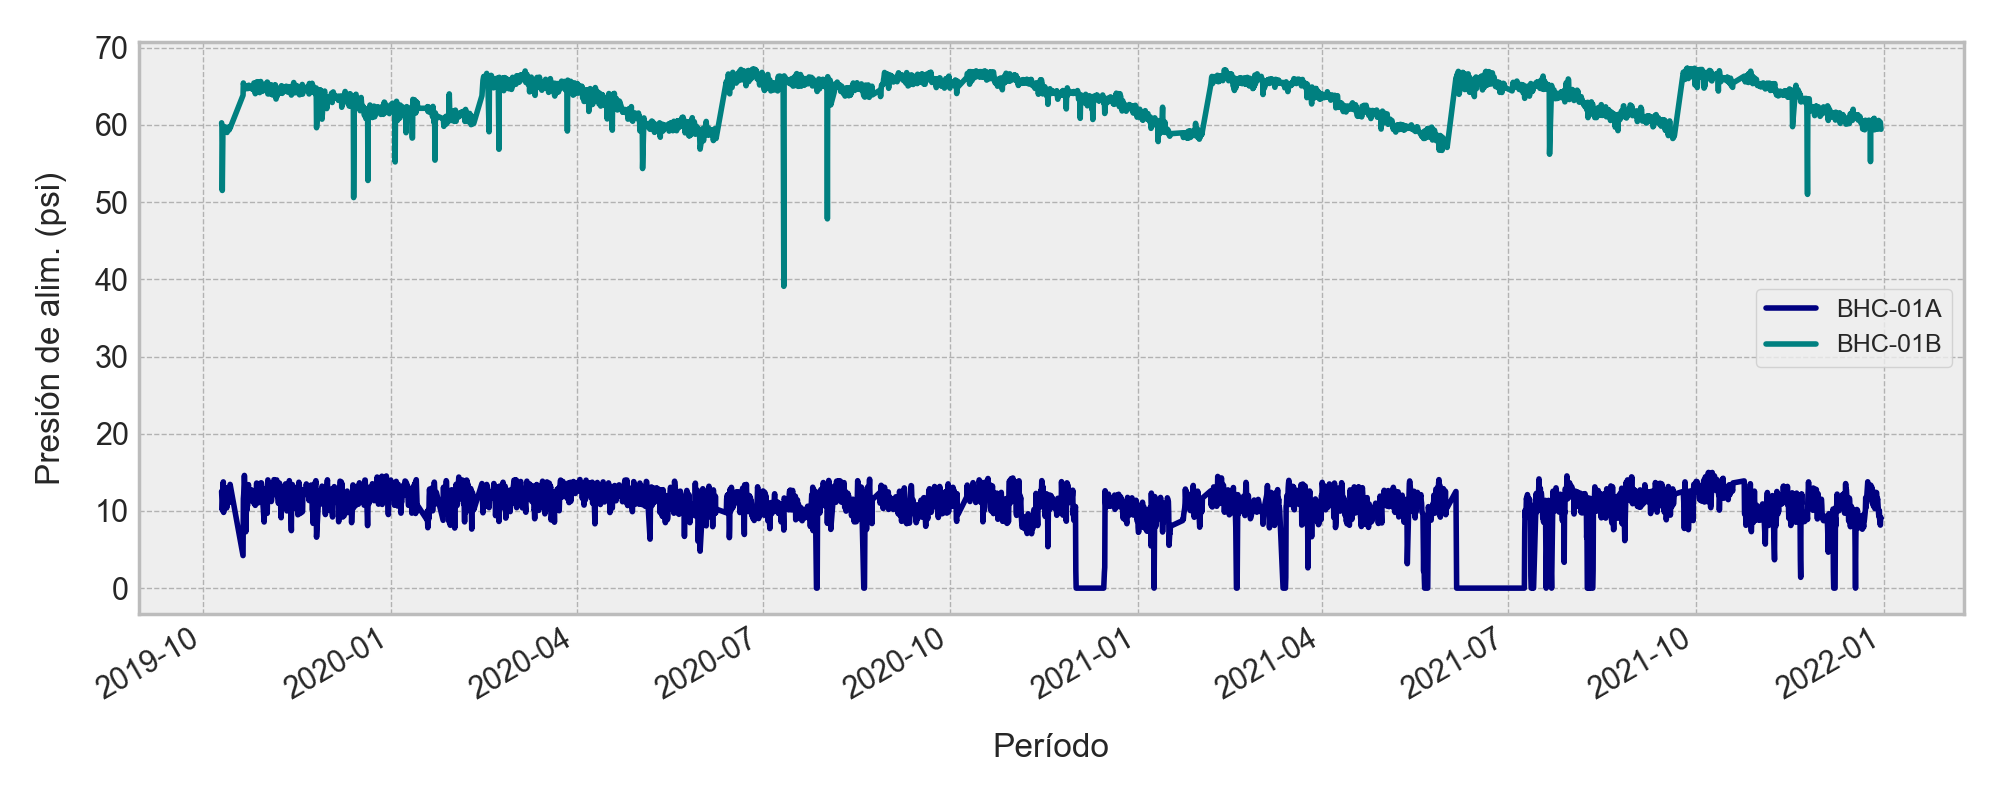

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))
df["pres_alim_bhc1a"].plot(ax=ax, color="navy", label="BHC-01A")
df["pres_alim_bhc1b"].plot(ax=ax, color="teal", label="BHC-01B")
ax.set_xlabel("Período", fontsize=12, labelpad=10)
ax.set_ylabel("Presión de alim. (psi)", fontsize=12, labelpad=10)
ax.legend(loc="best", fontsize=9, frameon=True)
plt.tight_layout();

Y ahí lo tenemos. Al parecer, es un problema de diferencia de unidades, a pesar de que inicialmente nos fue informado que ambas baterías están sensorizadas en "psi". Es muy probable que la presión de alimentación de la batería BHC-01B esté medida en kgf/m$^{2}$. Y, como sea, no parece haber motivos para descartar estas variables.

A continuación, generaremos un procedimiento sencillo para determinar la cantidad de *outliers* (datos anómalos) por variable. Debido a que este proceso es válido únicamente para variables numéricas, extraeremos tales variables por medio del método `select_dtypes()`. Luego, definiremos como *outlier* a todo punto, en cada variable, que, en un espacio estandarizado, se encuentre más de tres desviaciones estándar alejado de la media. Para ello, generaremos una transformación del set de variables numéricas a otro set de variables con distribución Gaussiana estándar por medio de la función `zscore()` del módulo `scipy.stats`, evitando considerar los valores que son `NaN`:

In [33]:
# Seleccionamos únicamente los datos numéricos de nuestro DataFrame.
df_numeric = df.select_dtypes(include=[np.number])

In [34]:
# Calculamos el puntaje normalizado estándar para cada variable.
z_scores = df_numeric.apply(zscore, nan_policy='omit')

In [35]:
# Identificamos outlies conforme Z > 3 o Z < -3
outliers = (np.abs(z_scores) > 3).sum()

Ahora graficamos nuestros resultados:

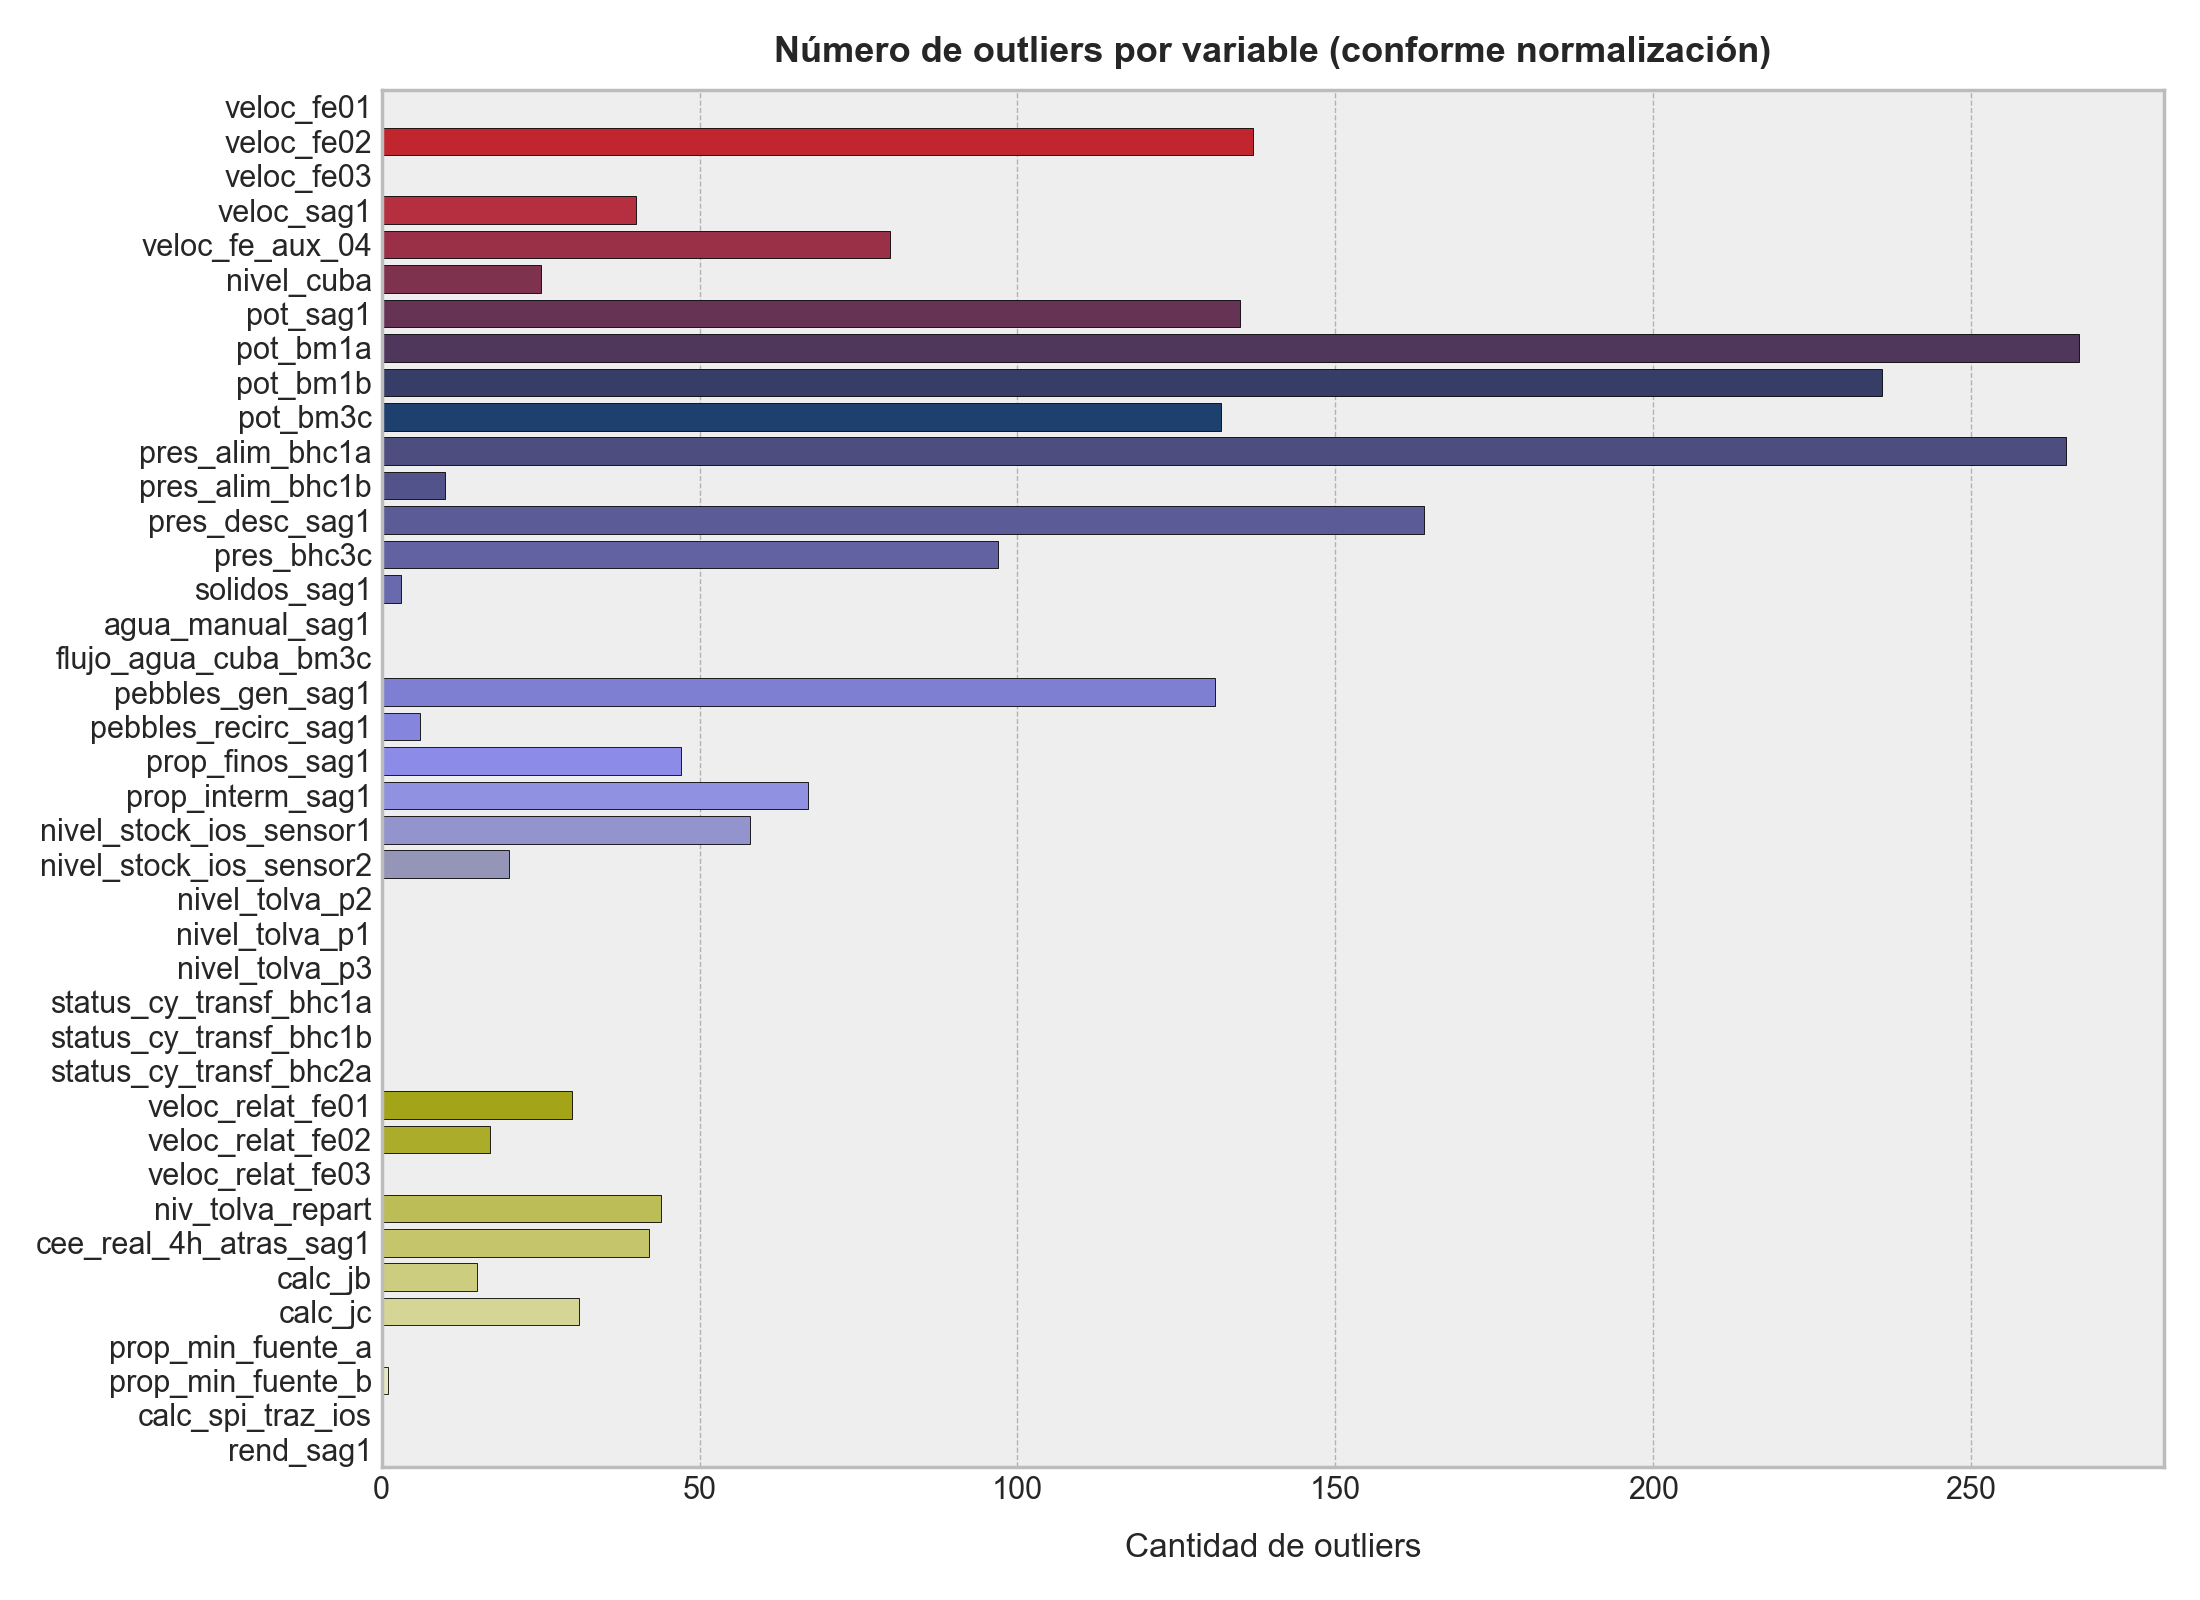

In [36]:
# Construimos un gráfico para mostrar el número de outliers por variable.
fig, ax = plt.subplots(figsize=(11, 8))
sns.barplot(
    y=outliers.index, x=outliers.values, hue=outliers.index, legend=False, 
    palette="gist_stern", lw=0.3, ec="black", orient="h", ax=ax,
)
ax.set_ylabel("", fontsize=12, labelpad=10)
ax.set_xlabel("Cantidad de outliers", fontsize=12, labelpad=10)
ax.set_title(
    "Número de outliers por variable (conforme normalización)", fontsize=13, 
    fontweight="bold", pad=10,
)
plt.tight_layout();

Debido a que, en promedio, cada variable de nuestro conjunto de datos tiene más de `3900` filas, podemos observar que el número de outliers por cada una de ellas es de, en el peor de los casos, 260 puntos, lo que representa un poco más del 6% de los datos. No hay razón para deshacernos de estos datos, pero esto puede cambiar, dependiendo de las necesidades de nuestro problema. Como, por el momento, apuntamos únicamente a construir un modelo que estime el rendimiento de molienda en función de estas variables, sin otro objetivo de negocio, esto debería ser suficiente.

Para seleccionar las variables que entrarán a nuestro modelo, construiremos una clase que realizará el proceso de limpieza de datos en base a los criterios previamente descritos. Llamaremos a este objeto `DataQualityFilter`, y lo construiremos a fin de que sea compatible con el uso de pipelines y/o procesos de optimización de hiperparámetros propios de **<font color='mediumorchid'>Scikit-Learn</font>**:

In [37]:
# Generamos una clase especializada para trabajar la calidad de nuestro conjunto de datos.
class DataQualityFilter(BaseEstimator, TransformerMixin):
    """
    Objeto que permite realizar un sencillo filtro de datos por calidad con base en varios 
    criterios:
    
    - Por registros vacíos (NaNs).
    - Por muy baja variabilidad.
    - Por cantidad de outliers.
    - Por cantidad de valores nulos.

    Salvo los NaNs, el resto de los criterios definen ciertos puntajes de calidad de 0 a 1 que
    nos permiten realizar una primera selección de variables independientes para el modelo de
    interés. Tales puntajes son simplemente la proporción de filas en cada columna que cumplen
    con tener el correspondiente problema de calidad. Los registros vacíos se imputan por medio
    de un algoritmo de k-vecinos más cercanos.
    
    """
    def __init__(
        self, 
        missing_threshold=0.3, 
        zero_threshold=0.7, 
        low_variance_threshold=0.05, 
        outlier_method="zscore", 
        outlier_threshold=1,
    ):
        """
        Método de inicialización de nuestro transformador.

        Parámetros:
        -----------
        - missing_threshold : Máxima proporción tolerable de registros vacíos en una variable.
        - zero_threshold : Máxima proporción tolerable de ceros en una variable.
        - low_variance_threshold : Mínima variabilidad tolerable en una variable.
        - outlier_method : Método de identificación de outliers. Las opciones disponibles son
            `zscore`, que define los outliers a partir de tres desviaciones estándar con res-
            pecto luego de transformar los datos a una variable normal estándar; e `iqr`, que
            define como outlier a todos aquellos datos que estén fuera del rango intercuartil
            de la variable correspondiente.
        - outlier_threshold : Número máximo de outliers tolerable en una variable.
        
        """
        # Atribuimos los parámetros de inicialización a nuestro objeto.
        self.missing_threshold = missing_threshold
        self.zero_threshold = zero_threshold
        self.low_variance_threshold = low_variance_threshold
        self.outlier_method = outlier_method
        self.outlier_threshold = outlier_threshold
        self.selected_features_ = None

    def fit(self, X, y=None):
        """
        Método que realizará la evaluación de calidad sobre la matriz de diseño y, si corresponde,
        sobre el correspondiente vector de valores de salida.

        Parámetros:
        -----------
        X : Arreglo de tamaño (m, n) que describe la matriz de diseño de interés.
        y : Arreglo de tamaño (m,) que describe el vector de valores de respuesta.
        
        """
        # Calculamos las métricas de calidad.
        missing_vals = X.isnull().mean()
        zero_vals = (X == 0).mean()
        low_var_vals = X.std() / X.mean()

        # Identificamos las variables en `X` con problemas de calidad.
        to_drop = set()
        to_drop.update(
            missing_vals[missing_vals >= self.missing_threshold].index
        )  # Eliminar variables con 100% de NaNs.
        to_drop.update(
            zero_vals[zero_vals == 1].index
        )  # Eliminar variables con 100% de ceros.
        to_drop.update(
            low_var_vals[low_var_vals == 1].index
        )  # Eliminar variables con 100% de varianza baja.
        
        # Detectamos los outliers.
        if self.outlier_method == "zscore":
            # Detección por normalización.
            z_scores = X.apply(zscore, nan_policy='omit')
            outliers = (np.abs(z_scores) > self.outlier_threshold).mean()
        elif self.outlier_method == "iqr":
            # Detección conforme rango intercuartil.
            Q1 = X.quantile(0.25)
            Q3 = X.quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).mean()
        else:
            # Levantamos una excepción si se provee algún criterio distinto de los 
            # soportados.
            msg = f"{self.outlier_method} no es un criterio de detección de outliers "\
            + "soportado por esta implementación. Los criterios soportados son "\
            + "`zscore` e `iqr`."
            ValueError(msg)

        # Eliminamos las variables con una determinada cantidad de valores considerados outliers.
        to_drop.update(outliers[outliers == self.outlier_threshold].index)

        # Excepciones: Mantener variables con 'status' o 'jc' en su nombre.
        to_keep = [col for col in X.columns if 'status' in col or 'jc' in col]
        to_drop = to_drop - set(to_keep)

        # Nos quedamos con las variables seleccionadas.
        self.selected_features_ = list(set(X.columns) - to_drop)
        return self

    def transform(self, X):
        """
        Método que nos permite aplicar la transformación de interés.
        """
        return X[self.selected_features_]

Al respecto, podemos observar que la clase se inicializa con un set de parámetros que definen umbrales de tolerancia en aspectos de calidad. Por defecto, `missing_threshold=0.3` establece que descartaremos toda variable que tenga más de un 30% de registros vacíos; `zero_threshold=0.7` establece que eliminaremos toda variable que tenga más 70% de concentración de valores iguales a cero; `low_variance_threshold=0.05` establece que eliminaremos toda variable cuya variabilidad sea menor que un 5%; y `outlier_threshold=1` establece que eliminaremo toda variable con un 100% de outliers. Esto último suena un tanto absurdo, pero es mayormente porque no estamos interesados, en este ejercicio, en eliminar variables en base a este último criterio.

Con nuestro "pre-procesador" ya listo, podemos partir con la construcción de nuestro modelo. Sin embargo, en esta oportunidad, debemos considerar un aspecto de gran importancia en nuestro conjunto de datos: **Cada variable, incluyendo la de respuesta, es de hecho una serie de tiempo** (ya que el DataFrame está indexado conforme un momento determinado en el tiempo). Por lo tanto, **el orden de las observaciones es único y fundamental**. Esto, por supuesto, restringe nuestras opciones a la hora de construir un modelo de regresión, ya que hay **dependencias temporales** entre las variables, incluso consigo mismas, que no están mapeadas explícitamente en el conjunto de datos. Algunos aspectos a considerar frente a casos como éste, al trabajar con **<font color='mediumorchid'>Scikit-Learn</font>**, son los siguientes:

- La ya mencionada dependencia temporal: A diferencia de los datos independientes e idénticamente distribuidos (iid), las observaciones adyacentes en el tiempo suelen estar correlacionadas. Esto afecta la suposición clásica de la mayoría de los modelos de regresión, ya que, en general, éstos asumen que las observaciones son, al menos, independientes.
- Autocorrelación: Tanto las variables de entrada como la de respuesta pueden presentar correlaciones consigo mismas respecto a un número determinado de pasos hacia atrás en el tiempo. El tamaño del paso, denominado *retardo* o *lag*, puede ser variable, pero introduce un nuevo nivel de dependencia que no se mapea de forma explícita en el conjunto de datos (por ejemplo, una variable $\mathbf{x}_{j}(t)$ podría estar correlacionada consigo misma $k$ pasos hacia atrás –o con un *lag* igual a $k$–, digamos $\mathbf{x}_{j}(t-k)$).

En general, es esperable que los modelos de regresión que no contemplan estructuras de serie de tiempo puedan dar lugar a estimaciones sesgadas o ineficientes, debido a la presencia de estas dependencias temporales. **<font color='mediumorchid'>Scikit-Learn</font>** ofrece algunas herramientas para compensar esta desventaja, pero en general, no es una librería pensada para discriminar si los conjuntos de datos a trabajar tienen o no dependencias del tiempo. Así que, en un caso como éste, tendremos que aceptar estas limitaciones, o bien, hacer uso de librerías que sí estén orientadas a modelar datos de este tipo con algoritmos de aprendizaje supervisado (como **<font color='mediumorchid'>Prophet</font>**, **<font color='mediumorchid'>SkForecast</font>** o **<font color='mediumorchid'>Darts</font>**).

Una forma de considerar las dependencias temporales en un conjunto de datos es construir variables con *lag*. Por ejemplo, si sabemos que las autocorrelaciones son significativas hasta $k$ pasos hacia atrás en el tiempo (donde el tamaño del paso equivale a la granularidad de nuestro conjunto de datos, 4 horas en este ejercicio), una "solución" para "ayudar" a nuestro modelo a considerar estas dependencias temporales puede ser incorporar estos valores al conjunto de datos como si fueran variables "nuevas". Aunque, por supuesto, hay un problema: Un *lag* igual a $k$ implica que la dimensionalidad de nuestro conjunto de entrenamiento también se multiplicará por $k$. Como veremos más adelante, al estudiar algoritmos de aptendizaje no supervisado, esto podría inducir que los datos se dispersen naturalmente en subespacios de menor dimensión, aumentando las correlaciones locales o cruzadas.

Por el momento, procederemos "como siempre", en el sentido de que no recurriremos a otras librerías ni tampoco consideraremos variables con *lag*, salvo `cee_real_4h_atras_sag1`, que representa el consumo específico de energía del molino SAG cuatro horas atrás (1 paso hacia atrás), ya que dicha variable fue entregada en el conjunto de datos original (sin considerar su valor actual).

Para tomar en cuenta el orden de las observaciones, sí definiremos un momento en el tiempo que separará a los datos de entrenamiento de los de prueba:

In [38]:
# Definimos la fecha que establece la separación entre datos de entrenamiento y de prueba
test_init = "2021-09-01 01:00:00"

También separaremos la correspondiente matriz de diseño del vector de valores de respuesta:

In [39]:
# Separamos el par `(X, y)`.
X, y = df.iloc[:, :-1].copy(), df.iloc[:, -1].copy()

In [40]:
# Generamos los conjuntos de entrenamiento y de prueba.
X_train, y_train = X.loc[:test_init].copy(), y[:test_init].copy()
X_test, y_test = X.loc[test_init:].copy(), y[test_init:].copy()

A continuación, creamos los objetos que describirán los modelos que serán parte del ensamble: Un modelo de regresión lineal regularizado de tipo "ridge", una máquina de soporte vectorial y un modelo de árbol de decisión. Para cada uno de ellos construiremos una pipeline dedicada de varios pasos:

- Un **filtro de calidad**, denominado `"quality_filter"`, que aplicará nuestra clase `DataQualityFilter` para limpiar los datos y generar una selección de variables "a priori".
- Una **estrategia de auto-imputación** denominada `"self_imputer"`, que rellenará los registros vacíos (`NaN`) haciendo uso de un algoritmo denominado **$k$-vecinos más cercanos**. Este método permite generar asignaciones en función de los $k$ puntos más cercanos a los registros sin datos, ponderando cada valor en función de la distancia (Euclidiana) entre ellos. De esta manera, preservamos la distribución de probabilidad observada de cada variable, a diferencia de lo que haríamos si imputáramos únicamente ceros o algún estadígrafo (como la media o la mediana). En **<font color='mediumorchid'>Scikit-Learn</font>**, este método de auto-imputación puede implementarse por medio de la clase `KNNImputer`, usando el parámetro `n_neighbors` para especificar el número de puntos vecinos a considerar en el análisis. Este proceso es computacionalmente costoso, y debe usarse en conjuntos de datos con pocos registros vacíos.
- Un proceso de **escalamiento** válido para el modelo de regresión lineal y la máquina de soporte vectorial, donde normalizamos el conjunto de datos.
- El instanciamiento del modelo de interés.

De esta manera, tenemos:

In [41]:
# Instanciamos los modelos de interés.
lin_reg_model = Ridge(max_iter=1000, random_state=42)
svm_reg_model = SVR()
tree_reg_model = DecisionTreeRegressor(random_state=42)

In [42]:
# Creamos las pipelines para cada uno de ellos.
linear_pipeline = Pipeline([
    ("quality_filter", DataQualityFilter(outlier_threshold=10)),
    ("self_imputer", KNNImputer(n_neighbors=10)),
    ("scaler", StandardScaler()),
    ("estimator", lin_reg_model),
])
svr_pipeline = Pipeline([
    ("quality_filter", DataQualityFilter(outlier_threshold=10)),
    ("self_imputer", KNNImputer(n_neighbors=10)),
    ("scaler", StandardScaler()),
    ("estimator", svm_reg_model),
])
tree_pipeline = Pipeline([
    ("quality_filter", DataQualityFilter(outlier_threshold=10)),
    ("self_imputer", KNNImputer(n_neighbors=10)),
    ("estimator", tree_reg_model),
])

Para asegurarnos que los modelos entrenados tengan la mejor calidad posible, generaremos una búsqueda aleatorizada de hiperparámetros por medio de un proceso de validación cruzada. Este proceso será un tanto diferente al que hemos venido aplicando precisamente por el hecho de que nuestro conjunto de datos está constituido por series de tiempo. Cuando el orden de las observaciones es importante, no es posible proceder por medio de una validación cruzada tradicional, porque el tomar puntos aleatorios de las series de tiempo involucradas para crear un conjunto de prueba destruirá cualquier tipo de dependencia temporal enmascarada en los datos. Para evitar este problema, existe una alternativa de validación cruzada que preserva el orden de las observaciones de un conjunto de datos de este tipo.

Debido a que no podemos mezclar información futura con información pasada durante el entrenamiento, el proceso de validación cruzada para conjuntos de datos ordenados cronológicamente simplemente realiza divisiones progresivas que simulan cómo se desplegaría un modelo en el tiempo. Cada partición entrena con datos del pasado y valida con datos del futuro inmediato. En cada paso, el conjunto de entrenamiento crece y el conjunto de prueba se desliza hacia adelante, manteniendo su tamaño constante.

Para generar este proceso, usaremos la clase `TimeSeriesSplit`, cuya dependencia es el módulo `sklearn.model_selection`, al igual que el resto de los objetos especializados en validación cruzada. Se trata de una herramienta especializada en series de tiempo. Solemos imputar, como mínimo, el número de particiones a generar del conjunto de entrenamiento mediante el parámetro `n_splits`, aunque también es posible especificar el tamaño máximo del subconjunto de entrenamiento en cada paso por medio del parámetro `max_train_size`, o bien, fijar el tamaño del conjunto de validación en cada paso como proporción del conjunto de datos completo por medio del parámetro `test_size`.

Definimos entonces los espacios de búsqueda para cada modelo:

In [43]:
# Definimos espacios de búsqueda con distribuciones adecuadas para ajustar los
# correspondientes hiperparámetros de cada modelo.
param_distributions_lin_reg = {
    'estimator__alpha': loguniform(1e-4, 1e2)
}
param_distributions_svr = {
    'estimator__C': loguniform(1e-2, 1e3),
    'estimator__epsilon': loguniform(1e-4, 1),
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__degree': randint(2, 5),
}
param_distributions_tree = {
    'estimator__max_depth': randint(3, 30),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 10),
}

A continuación, para ahorrarnos algo de código, definiremos una sencilla función que se hará cargo de la búsqueda de hiperparámetros:

In [44]:
# Definimos nuestras rutinas de búsqueda aleatorizada.
def hyperparameter_tunning(model):
    if model == "linear":
        return RandomizedSearchCV(
            estimator=linear_pipeline,
            param_distributions=param_distributions_lin_reg,
            scoring="r2",
            refit="r2",
            n_jobs=-1,
            cv=TimeSeriesSplit(n_splits=10),
            verbose=1,
            n_iter=500,
            random_state=42,
        )
    elif model == "svm":
        return RandomizedSearchCV(
            estimator=svr_pipeline,
            param_distributions=param_distributions_svr,
            scoring="r2",
            refit="r2",
            n_jobs=-1,
            cv=TimeSeriesSplit(n_splits=10),
            verbose=1,
            n_iter=200,
            random_state=42,
        )
    elif model == "tree":
        return RandomizedSearchCV(
            estimator=tree_pipeline,
            param_distributions=param_distributions_tree,
            scoring="r2",
            refit="r2",
            n_jobs=-1,
            cv=TimeSeriesSplit(n_splits=10),
            verbose=1,
            n_iter=500,
            random_state=42,
        )
    else:
        msg = f"`{model}` no es un modelo válido en la definición de la"\
        + " rutina de búsqueda de hiperparámetros. Los modelos aceptados"\
        + " por esta rutina son `linear`, `svm` y `tree`."
        raise ValueError(msg)

Y ya estamos listos para entrenar nuestros modelos por separado. Instanciaremos nuestras búsquedas vía validación cruzada y generamos los ajustes correspondientes. Este proceso puede tardar algunos minutos, así que a no desesperar:

In [45]:
# Instanciamos nuestras búsquedas.
optimizer_lin_reg = hyperparameter_tunning(model="linear")
optimizer_svm_reg = hyperparameter_tunning(model="svm")
optimizer_tree_reg = hyperparameter_tunning(model="tree")

In [46]:
# Búsqueda de hiperparámetros para modelo de regresión lineal.
optimizer_lin_reg.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('quality_filter',
                                              DataQualityFilter(outlier_threshold=10)),
                                             ('self_imputer',
                                              KNNImputer(n_neighbors=10)),
                                             ('scaler', StandardScaler()),
                                             ('estimator',
                                              Ridge(max_iter=1000,
                                                    random_state=42))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'estimator__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8cb79e2400>},
                   random_state=42, refit='r2', scoring='r2', verbose=1)

In [47]:
# Búsqueda de hiperparámetros para máquina de soporte vectorial.
optimizer_svm_reg.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('quality_filter',
                                              DataQualityFilter(outlier_threshold=10)),
                                             ('self_imputer',
                                              KNNImputer(n_neighbors=10)),
                                             ('scaler', StandardScaler()),
                                             ('estimator', SVR())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'estimator__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8cb79fd220>,
                                        'estimator__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8cb79fd3d0>,
                                        'estimator__epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8cb79e21f0>,
                                        'estimator__kernel': ['linear', 'rbf',
                                                              'poly']},
                   random_state=42, refit='r2', scoring='r2', verbose=1)

In [48]:
# Búsqueda de hiperparámetros para árbol de regresión.
optimizer_tree_reg.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


/Users/felipequezada/.local/share/virtualenvs/udd_data_science_lectures-cIJkRdo8/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('quality_filter',
                                              DataQualityFilter(outlier_threshold=10)),
                                             ('self_imputer',
                                              KNNImputer(n_neighbors=10)),
                                             ('estimator',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8cb7947a30>,
                                        'estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8cb79fff10>,
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8cb79fd670>},
                   random_state=42, refit='r2', scoring='r2', verbose=1)

Para cada caso, seleccionamos los modelos con los mejores resultados, en promedio, en los conjuntos de validación y graficamos los resultados para cada caso:

In [49]:
# Recuperamos los mejores modelos.
best_lin_model = optimizer_lin_reg.best_estimator_
best_svm_model = optimizer_svm_reg.best_estimator_
best_dtr_model = optimizer_tree_reg.best_estimator_

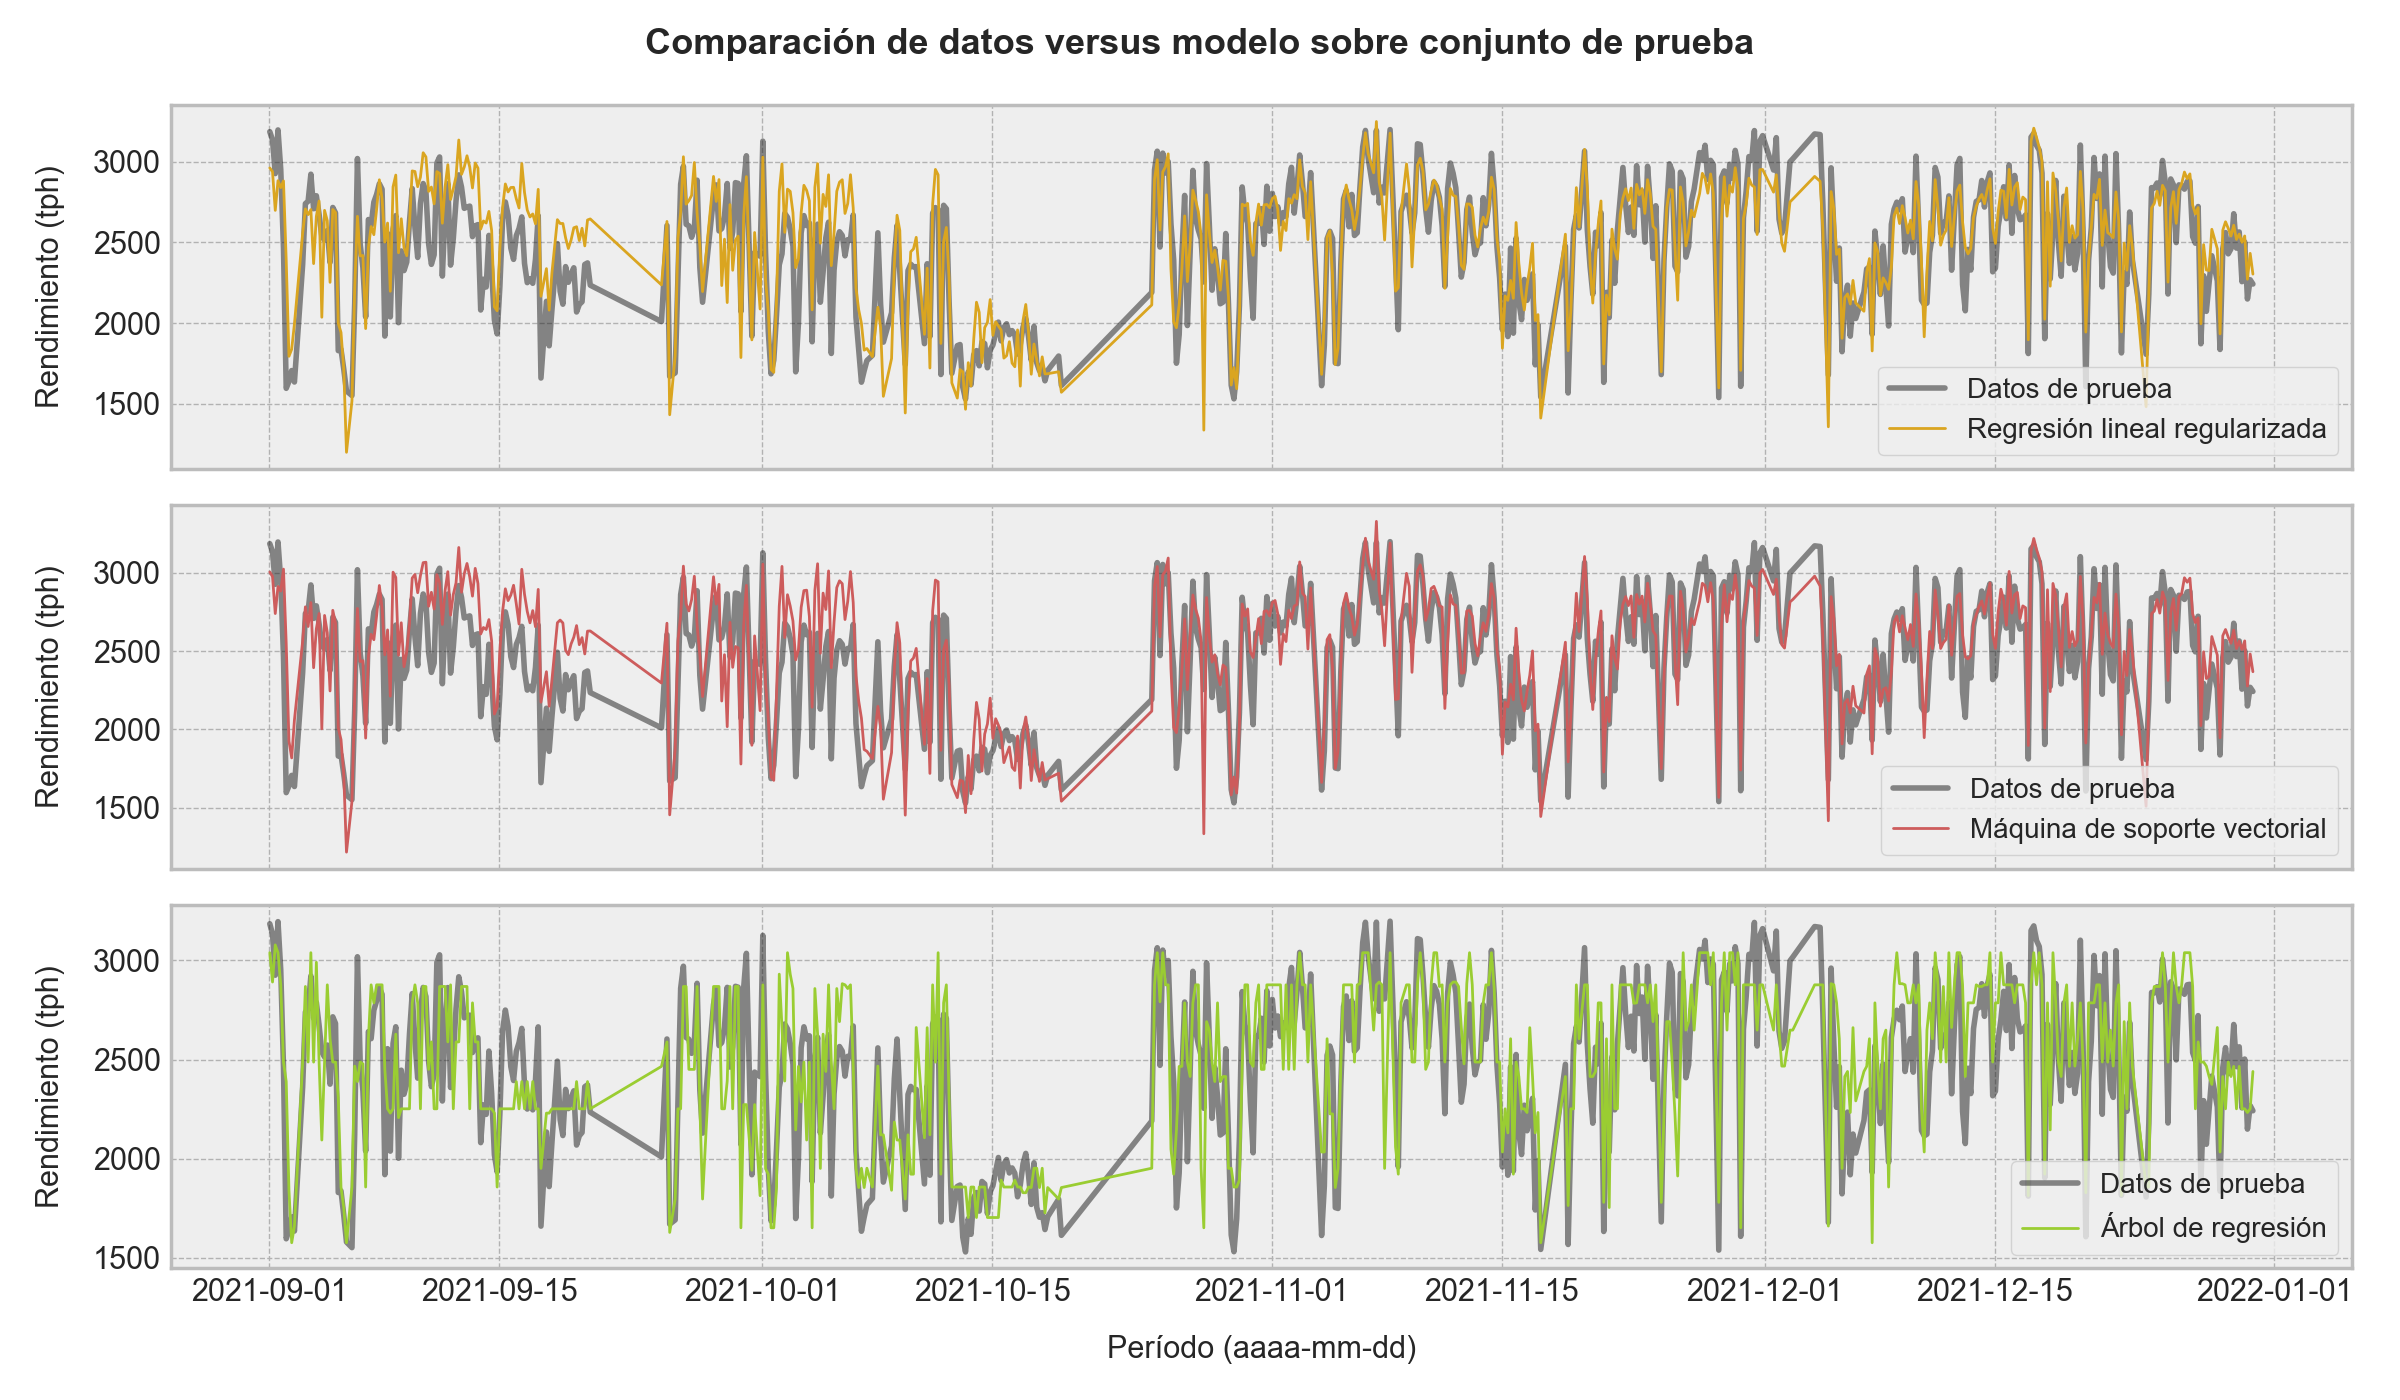

In [50]:
# Graficamos los resultados.
models = [best_lin_model, best_svm_model, best_dtr_model]
names = ["Regresión lineal regularizada", "Máquina de soporte vectorial", "Árbol de regresión"]
colors = ["goldenrod", "indianred", "yellowgreen"]

fig, ax = plt.subplots(figsize=(12, 7), nrows=3, sharex=True)

for k, model_k in enumerate(models):
    y_test_pred_k = model_k.predict(X_test)
    ax[k].plot(y_test.index, y_test.values, alpha=0.5, color="k", lw=2.0, label="Datos de prueba")
    ax[k].plot(y_test.index, y_test_pred_k, color=colors[k], lw=1.0, label=names[k])
    ax[k].legend(loc="best", fontsize=10, frameon=True)
    ax[k].set_ylabel("Rendimiento (tph)", fontsize=11, labelpad=10)

ax[-1].set_xlabel("Período (aaaa-mm-dd)", fontsize=11, labelpad=10)
fig.suptitle("Comparación de datos versus modelo sobre conjunto de prueba", fontsize=13, fontweight="bold")
plt.tight_layout();

Todos los modelos parecen reproducir, en parte, la tendencia de la serie de rendimiento para nuestro molino SAG. Algunos con más problemas que otros, por supuesto. A fin de evaluar la calidad, de cada uno de estos modelos, construiremos algunos gráficos sencillos que mostrarán la dispersión entre los rendimientos reales y predichos por cada uno, presentando en cada caso tres indicadores de desempeño (coeficiente $r^{2}$, error medio absoluto y raíz del error cuadrático medio). Recordemos que, para gráficos de este tipo, el comportamiento ideal es que los puntos sigan una recta de ecuación $y=x$ (es decir, que `y == y_pred`), llamada **línea de ajuste perfecto**. Naturalmente, este no será el caso, puesto que cada modelo comete algunos errores:

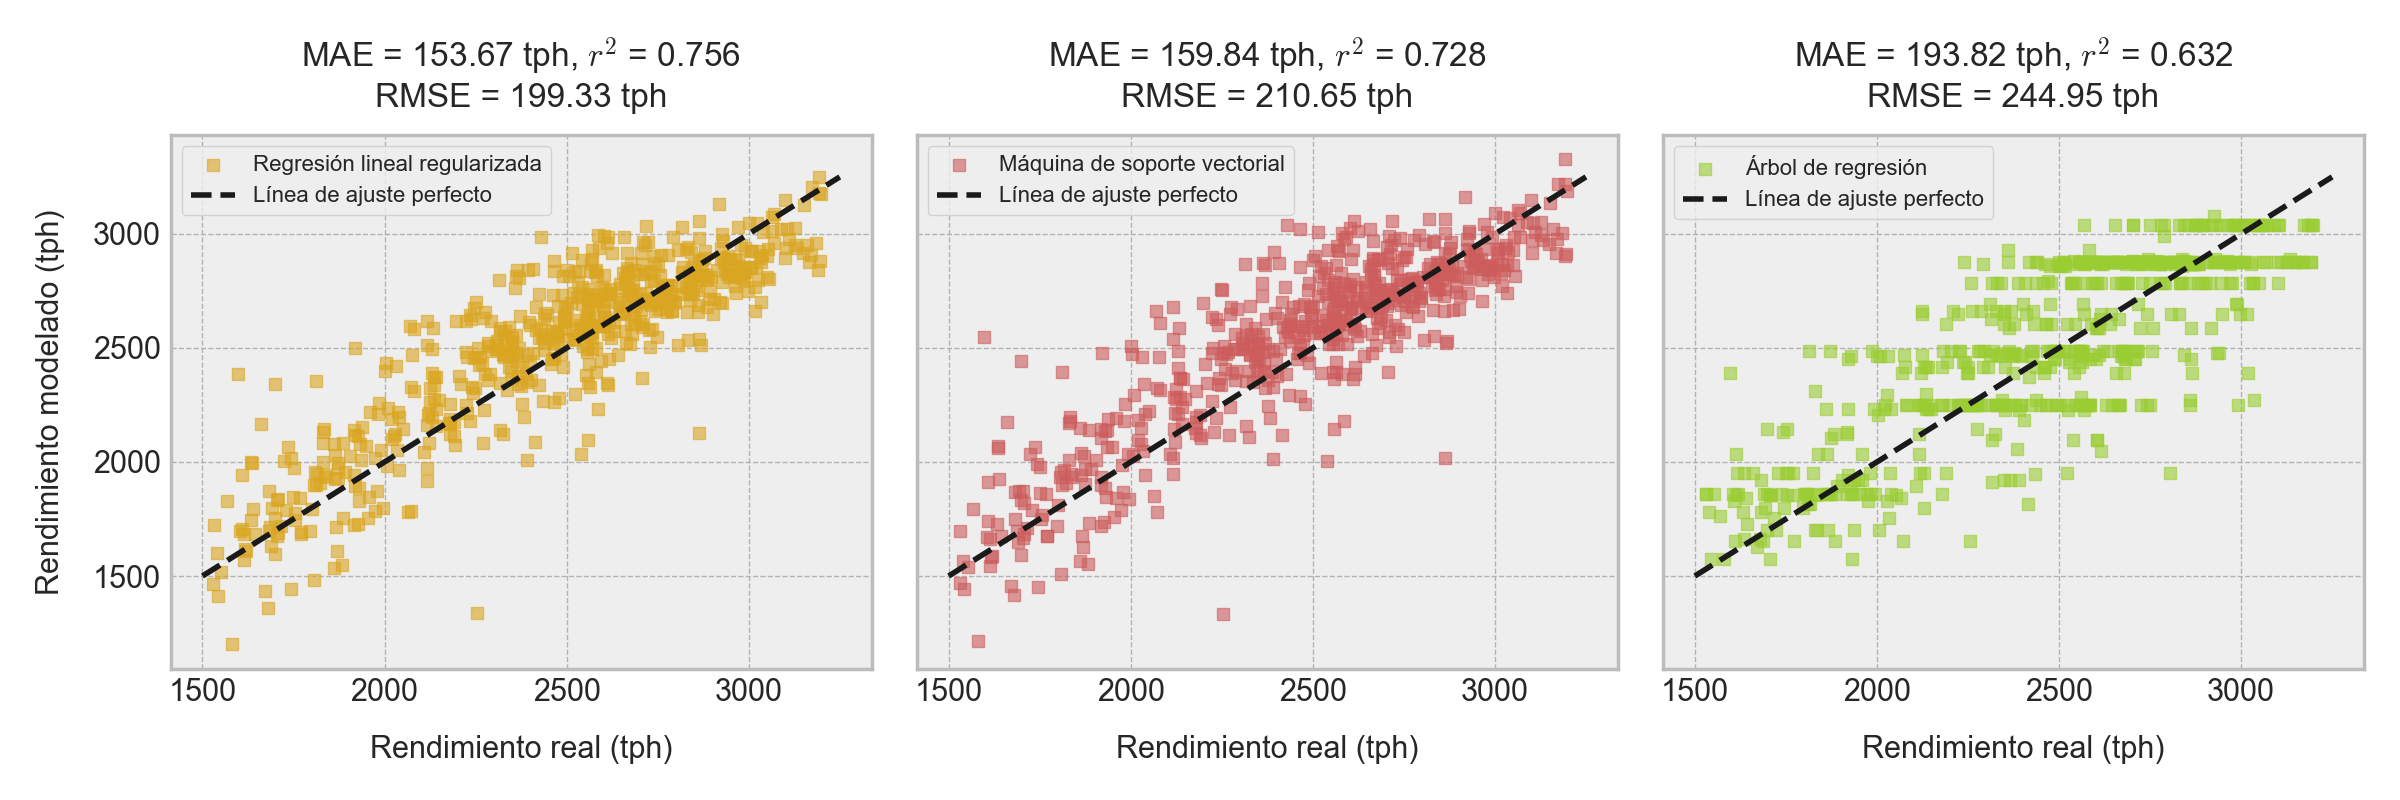

In [51]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3, sharey=True)
full_tph_tange = np.linspace(1500, 3250, 100)

for k, model_k in enumerate(models):
    y_test_pred_k = model_k.predict(X_test)
    test_mae_k = mean_absolute_error(y_test, y_test_pred_k)
    test_r2_k = r2_score(y_test, y_test_pred_k)
    test_rmse_k = root_mean_squared_error(y_test, y_test_pred_k)
    title = "MAE = {0:0.2f} tph".format(test_mae_k) \
        + r", $r^{2}$" + " = {0:0.3f}".format(test_r2_k)\
        + "\nRMSE = {0:0.2f} tph".format(test_rmse_k)
    ax[k].scatter(x=y_test, y=y_test_pred_k, color=colors[k], s=20, marker="s", alpha=0.6, label=names[k])
    ax[k].plot(full_tph_tange, full_tph_tange, "k--", label="Línea de ajuste perfecto")
    ax[k].legend(loc="best", fontsize=8, frameon=True)
    ax[k].set_xlabel("Rendimiento real (tph)", fontsize=11, labelpad=10)
    ax[k].set_title(title, fontsize=12, pad=10)

ax[0].set_ylabel("Rendimiento modelado (tph)", fontsize=11, labelpad=10)
plt.tight_layout();

Tanto el modelo de regresión de tipo "ridge" como la máquina de soporte vectorial presentan un comportamiento bastante aceptable con respecto a la línea de ajuste perfecto. El modelo de árbol de decisión, por otro lado, presenta un comportamiento tal que los correspondientes puntos se agrupan horizontalmente con respecto a dicha línea, lo que resulta en un rendimiento menor que los otros dos. Esto es algo esperado en este tipo de modelos.

Procedemos ahora con la construcción del ensamble por votación usando como componentes a los modelos anteriores. Para ello, simplemente nos valemos de los modelos ya entrenados (con sus mejores hiperparámetros):

In [52]:
# Creamos un ensamble a partir de los modelos anteriores.
voting_reg = VotingRegressor(
    estimators=[
        ("linear_regression", best_lin_model),
        ("support_vector_machine", best_svm_model),
        ("decision_tree", best_dtr_model),
    ]
)

In [53]:
# Entrenamos nuestro ensamble.
voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('linear_regression',
                             Pipeline(steps=[('quality_filter',
                                              DataQualityFilter(outlier_threshold=10)),
                                             ('self_imputer',
                                              KNNImputer(n_neighbors=10)),
                                             ('scaler', StandardScaler()),
                                             ('estimator',
                                              Ridge(alpha=50.61576888752309,
                                                    max_iter=1000,
                                                    random_state=42))])),
                            ('support_vector_machine',
                             Pipeline(steps=[('quality_filter',
                                              DataQualityFilte...
                                             ('scaler', StandardScaler()),
                                             ('estimator',
                                              SVR(C=4.08522800366862, degree=2,
                                                  epsilon=0.001219471523337766,
                                                  kernel='linear'))])),
                            ('decision_tree',
                             Pipeline(steps=[('quality_filter',
                                              DataQualityFilter(outlier_threshold=10)),
                                             ('self_imputer',
                                              KNNImputer(n_neighbors=10)),
                                             ('estimator',
                                              DecisionTreeRegressor(max_depth=7,
                                                                    min_samples_leaf=8,
                                                                    min_samples_split=13,
                                                                    random_state=42))]))])

Y visualizamos los resultados:

Error medio absoluto = 144.63 tph
Error cuadrático medio (en raíz) = 187.59 tph
Coeficiente r2 = 0.784


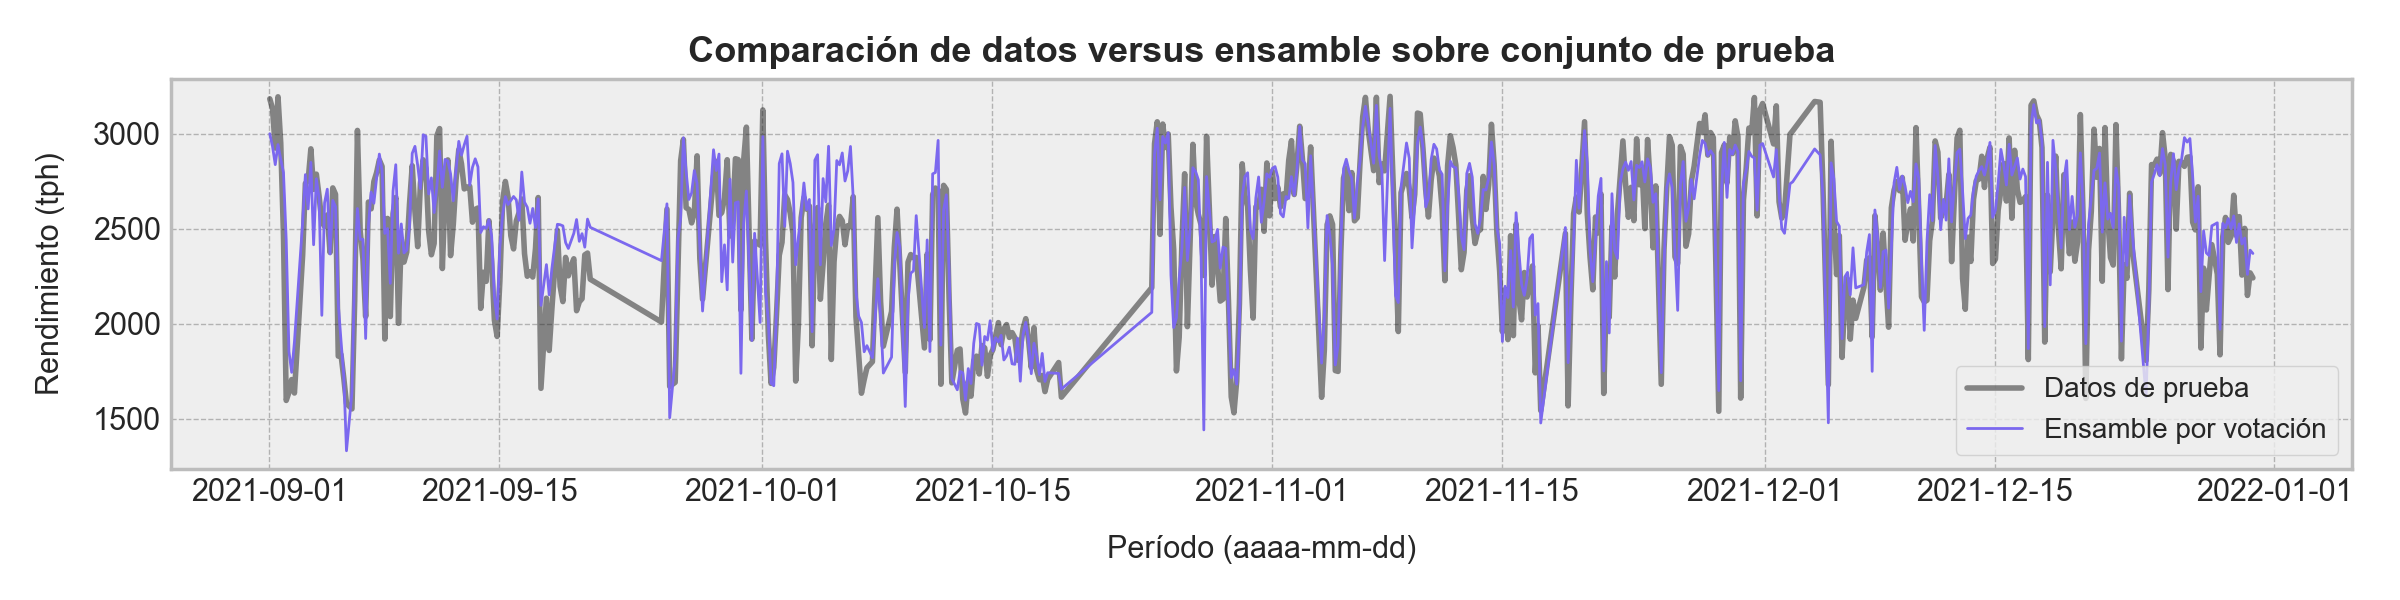

In [54]:
# Visualizamos los resultados de nuestro ensamble.
fig, ax = plt.subplots(figsize=(12, 3))

# Generamos predicciones sobre el conjunto de prueba.
y_test_pred_ens = voting_reg.predict(X_test)

# Calculamos los KPIs de desempeño del mensamble.
test_mae_ens = mean_absolute_error(y_test, y_test_pred_ens)
test_r2_ens = r2_score(y_test, y_test_pred_ens)
test_rmse_ens = root_mean_squared_error(y_test, y_test_pred_ens)

# Mostramos la comparación de la señal real de rendimiento versus la modelada.
ax.plot(y_test.index, y_test.values, alpha=0.5, color="k", lw=2.0, label="Datos de prueba")
ax.plot(y_test.index, y_test_pred_ens, color="mediumslateblue", lw=1.0, label="Ensamble por votación")
ax.legend(loc="best", fontsize=10, frameon=True)
ax.set_ylabel("Rendimiento (tph)", fontsize=11, labelpad=10)
ax.set_xlabel("Período (aaaa-mm-dd)", fontsize=11, labelpad=10)
ax.set_title("Comparación de datos versus ensamble sobre conjunto de prueba", fontsize=13, fontweight="bold")

# Mostramos en pantalla los valores de cada KPI de desempeño.
print("Error medio absoluto = {0:0.2f} tph".format(test_mae_ens))
print("Error cuadrático medio (en raíz) = {0:0.2f} tph".format(test_rmse_ens))
print("Coeficiente r2 = {0:0.3f}".format(test_r2_ens))

plt.tight_layout();

Observamos que nuestro ensamble tiene un desempeño mejor que cualquiera de sus componentes individuales y para todos los indicadores de calidad que hemos escogido. Indudablemente, este modelo "colectivo" es una elección mucho más razonable que cualquiera de sus componentes, ya que hereda todas las ventajas (y desventajas) de cada una, como cabría esperar, puesto que la calidad de éstas no es demasiado diferente. Esto pone de manifiesto el poder de este tipo de constructos. Aunque claro... A un costo alto, ya que nuestro procedimiento ha sido extenso.

En ejemplos posteriores, retomaremos este conjunto de datos. ◼︎

## Bagging.

### Intuición.
Los ensambles por votación constituyen el primer intento serio de construir un modelo colectivo (constituido por predictores individuales), pero con ciertas desventajas. La más importante de ellas estriba en exigir que los predictores individuales del ensamble sean estadísticamente independientes, lo que es virtualmente imposible en la práctica. Sin embargo, podemos inducir un cierto nivel de independencia estadística alterando la forma en la cual cada modelo "consume" los datos de entrenamiento, generando un muestreo diferente en cada caso. La técnica de **bagging** (acrónimo del término *bootstrap aggregating*) es una de las muchas técnicas que permite lograr este efecto, y se trata de la base de uno de los algoritmos de aprendizaje más poderosos en el mercado.

Sea $\mathcal{D}$ un conjunto de entrenamiento constituido por un total de $m$ instancias. La técnica de *bagging* nos permite generar un total de $r$ subconjuntos de entrenamiento $\mathcal{D}_{1},...,\mathcal{D}_{r}$, cada uno de tamaño $m'$, por medio de un **proceso de muestreo uniforme con reemplazo** de las instancias de $\mathcal{D}$. El reemplazo de las instancias durante el muestreo permitirá que algunas de ellas aparezcan en cada subconjunto $\mathcal{D}_{k}$ de forma repetida (para $k=1,...,r$), en la forma de "duplicados". Si $m'=m$, entonces, para un $m$ muy grande, se espera que el subconjunto $\mathcal{D}_{r}$ tenga una fracción total de $1-\frac{1}{e}$ instancias únicas (aproximadamente un 63.2%), siendo el resto duplicados de tales instancias. Esta técnica de muestreo se conoce, en la práctica, como **bootstrap sampling**. El efecto del reemplazo radica en que cada muestra de instancias de entrenamiento será independiente de las demás, ya que su elección no depende de las instancias que no pertenecen a cada subconjunto de entrenamiento. 

Una vez realizado el muestreo anterior, se entrena un modelo por cada uno de los subconjuntos de entrenamiento resultantes, dando lugar a un ensamble con $r$ modelos componentes que, dependiendo del problema de interés (clasificación o regresión), retornarán una predicción global basada en una determinada regla (votación mayoritaria o proporcional, o respuestas agregadas, respectivamente).

<p style="text-align: center;"><img src="figures/fig_7_2.png" width="1000"></p>
<p style="text-align: center;">Fig. (7.3): Ilustración del procedimiento de bagging a partir de un conjunto de entrenamiento. En el paso de muestreo por bootstrap, construimos varios subconjuntos de entrenamiento que estarán constituidos por una serie de instancias que pueden o no ser únicas, y luego entrenamos un modelo sobre cada uno de estos subconjuntos. Finalmente, en el proceso de agregación, generamos –valga la redundancia– una predicción agregada que será la salida de nuestro ensamble</p>

### Algunos paradigmas de "ensamblaje".
Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right) :\mathbf{X} \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento constituido por una matriz de diseño $\mathbf{X}$ y un vector de valores de respuesta $\mathbf{y}$. En términos bien generales, de acuerdo a como generamos los modelos componentes, existen dos grandes **paradigmas de ensamblaje**: El primero corresponde al **ensamblaje secuencial** de modelos componentes, donde éstos se van generando uno tras otro, siendo los modelos de **AdaBoost**, **gradient boosting** y **XGBoost** ejemplos de este paradigma. El segundo corresponde al **ensamblaje en paralelo**, que permite generar un colectivo de modelos que trabajan al unísono de manera tal que las predicciones del ensamble constituyen la respuesta agregada o por votación (dependiendo del tipo de problema de interés) de los modelos individuales. Ejemplos de este paradigma corresponden a los ensambles por bagging y voting.

La motivación que subyace el estudio de los ensambles secuenciales corresponde a la explotación de las dependencias entre los modelos componentes del ensamble, lo que veremos más adelante. Por el contrario, los ensambles en paralelo explotan la independencia entre estos modelos, ya que, como vimos previamente, el error cometido por ellos puede reducirse enormemente al combinarlos.

En el siguiente ejercicio, mostraremos que el error de generalización de un ensamble en paralelo decrece exponencialmente con respecto a su tamaño (el número de modelos componentes). Para ello, haremos uso el siguiente resultado.

**<font color='indianred'>Teorema 7.2 – Desigualdad de Hoeffding:</font>** *Sea $X_{1},...,X_{r}$ una colección de $r$ variables aleatorias independientes y acotadas en un intervalo cerrado del tipo $[a_{k},b_{k}]$ para cada $k=1,...,r$, tales que $\mathrm{E}[X_{k}]=\mu_{k}$. Entonces, para cualquier $\epsilon>0$ se cumple que*

$$P\left( \left| \frac{1}{r} \sum_{k=1}^{r} X_{k}-\frac{1}{r} \sum_{k=1}^{r} \mu_{k} \right| \geq \epsilon \right) \leq 2\exp \left( -\frac{2r^{2}\epsilon^{2}}{\sum\nolimits_{k=1}^{r} \left( b_{k}-a_{k} \right)^{2}} \right)$$
<p style="text-align: right;">$(7.19)$</p>

*Notemos que, si $0\leq X_{k}\leq 1$ y $\mathrm{E}[X_{k}]=p$ para todo $k=1,...,r$, la expresión anterior toma la forma reducida*

$$P\left( \left| \frac{1}{r} \sum_{k=1}^{r} X_{k}-p \right| \geq \epsilon \right) \leq 2\exp \left( -2r\epsilon^{2} \right)$$
<p style="text-align: right;">$(7.22)$</p>
□

**Ejemplo 7.4 – Decrecimiento exponencial del error de generalización de un ensamble conforme su tamaño:** Sin pérdida de generalidad, supongamos que el conjunto de entrenamiento $\mathcal{D}$ describe un problema de clasificación binaria, donde el correspondiente espacio de salida es $\mathcal{Y} =\left\{ -1,+1 \right\}$. Sea $\Lambda =\left\{ h_{k}:\mathcal{X}_{k} \longrightarrow \mathcal{Y}_{k} \right\}_{k=1}^{r}$ un conjunto de $r$ modelos definidos sobre distintas particiones (no necesariamente disjuntas) $\mathcal{X}_{1},...,\mathcal{X}_{r}$ del espacio de entrada $\mathcal{X}$ que define a $\mathcal{D}$, y que constituyen un ensamble (en paralelo), donde llamamos a $r$ el **tamaño del ensamble**. Supongamos que $f:\mathcal{X}\longrightarrow \mathcal{Y}$ es una función que representa la "verdadera" relación (o *verdad absoluta*) entre $\mathbf{X}$ e $\mathbf{y}$. El **error de generalización** asociado a cada uno de los $r$ modelos componentes puede definirse como la probabilidad de que $h_{k}(\mathbf{X})$ sea distinto de $f(\mathbf{X})$. Es decir,

$$E\left( h_{k},\mathcal{D} \right) =P\left( h_{k}\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right) \right) \  ;\  k=1,...,r$$
<p style="text-align: right;">$(7.23)$</p>

Llamaremos simplemente $\epsilon$ a este error de generalización.

Equivalentemente, si definimos la variable aleatoria $X_{k}$, definida como

$$X_{k}=\begin{cases}1&;\  \mathrm{si} \  h_{k}\left( \mathbf{X} \right) =f\left( \mathbf{X} \right)\\ 0&;\  \mathrm{si} \  h_{k}\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right)\end{cases}$$
<p style="text-align: right;">$(7.24)$</p>

Entonces, la ecuación (7.23) equivale a

$$P\left( X_{k}=1 \right) =1-\epsilon \  \wedge \  P\left( X_{k}=0 \right) =\epsilon$$
<p style="text-align: right;">$(7.25)$</p>

A diferencia de lo que hicimos al presentar los fundamentos matemáticos de los ensambles por votación, donde construimos dichos ensambles sumando variables aleatorias resultantes del éxito o fracaso de las predicciones de cada modelo individual (de acuerdo a sus probabilidades de acierto), combinaremos ahora tales modelos de acuerdo a sus predicciones absolutas. Es decir, como $h_{k}(\mathbf{X})$ sólo puede tomar, al igual que $f(\mathbf{X})$, los valores $-1$ y $+1$, entonces la suma $S$ de ellos, que equivale a la **salida del ensamble**, puede escribirse como

$$S\left( \mathbf{X} \right) =\mathrm{sgn} \left( \sum_{k=1}^{r} h_{k}\left( \mathbf{X} \right) \right)$$
<p style="text-align: right;">$(7.26)$</p>

Notemos que la salida $S(\mathbf{X})$ del ensamble coincidirá con el "valor real" $f(\mathbf{X})$ si y sólo si la salida de la mayoría de los predictores individuales $h_{1},...,h_{r}$ también coincide con dicho "valor real". Es decir,

$$S\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right) \  \Longleftrightarrow \  \sum_{k=1}^{r} X_{k}\leq \frac{r}{2}$$
<p style="text-align: right;">$(7.27)$</p>

De esta manera, la probabilidad de que el ensamble falle al predecir $\mathbf{X}$ será

$$P\left( S\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right) \right) =P\left( \sum_{k=1}^{r} X_{k}\leq \frac{r}{2} \right)$$
<p style="text-align: right;">$(7.28)$</p>

Si los $r$ predictores individuales $h_{1},...,h_{r}$ son independientes (o, como mínimo, presentan una correlación despreciable), entonces la variable aleatoria $S=S(\mathbf{X})$ representará el resultado de un total de $r$ experimentos de Bernoulli, cada uno de ellos con probabilidad de éxito igual a $1-\epsilon$, por lo que ésta seguirá igualmente una distribución de Bernoulli de parámetro $1-\epsilon$:

$$P\left( S\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right) \right) =\sum_{k=0}^{\left\lfloor r/2 \right\rfloor} \left( \begin{matrix}r\\ k\end{matrix} \right) \left( 1-\epsilon \right)^{k} \epsilon^{r-k}$$
<p style="text-align: right;">$(7.29)$</p>

La expresión (7.29) representa, indudablemente, el **error de generalización del ensamble completo**, que corresponde a la probabilidad de que la salida del ensamble no sea igual a la *verdad absoluta* definida en el conjunto de entrenamiento. 

Notemos que, a partir de la ecuación (7.29), observamos que $\mathrm{E} \left[ X_{k} \right] =1-\epsilon$. Si deseamos encontrar una cota superior para este error, entonces dicho problema equivale a acotar la probabilidad de que el ensamble no acierte en su predicción. Aplicando el toerema (7.2), dicha cota puede formularse como

$$\begin{array}{lll}\displaystyle P\left( \sum_{k=1}^{r} X_{k}\leq \frac{r}{2} \right)&=&\displaystyle P\left( \frac{1}{r} \sum_{k=1}^{r} X_{k}\leq \frac{1}{2} \right)\\ &=&\displaystyle P\left( \frac{1}{r} \sum_{k=1}^{r} X_{k}-\left( 1-\epsilon \right) \leq \frac{1}{2} -\left( 1-\epsilon \right) \right)\\ &=&\displaystyle P\left( \frac{1}{r} \sum_{k=1}^{r} X_{k}-\left( 1-\epsilon \right) \leq -\underbrace{\left( \frac{1}{2} -\epsilon \right)}_{=\delta} \right)\\ &=&\displaystyle P\left( \frac{1}{r} \sum_{k=1}^{r} X_{k}-\left( 1-\epsilon \right) \leq -\delta \right)\\ &\leq&\displaystyle 2\exp \left( -2r\delta^{2} \right)\\ &\leq&\displaystyle 2\exp \left( -2r\left( \frac{1}{2} -\epsilon \right)^{2} \right)\\ &\leq&\displaystyle 2\exp \left( -2r\frac{\left( 2\epsilon -1 \right)^{2}}{4} \right)\\ &\leq&\displaystyle 2\exp \left( -\frac{r}{2} \left( 2\epsilon -1 \right)^{2} \right)\end{array}$$
<p style="text-align: right;">$(7.30)$</p>

Por lo tanto, $P\left( S\left( \mathbf{X} \right) \neq f\left( \mathbf{X} \right) \right) \leq 2\exp \left( -\frac{r}{2} \left( 2\epsilon -1 \right)^{2} \right)$ es la cota buscada. De esta manera, si cada uno de los predictores individuales del ensamble acierta en su predicción con probabilidad $1-\epsilon> \frac{1}{2}$, y tales predictores tienen correlaciones despreciables, entonces la probabilidad de que el ensamble fracase en su predicción decrece exponencialmente con respecto a su tamaño $r$.

Aunque es prácticamente imposible que los predictores individuales de un ensamble sean estadísticamente independientes, ya que éstos suelen generarse a partir del mismo conjunto de entrenamiento, las técnicas de ensamblaje en paralelo (como el bagging) permiten reducir las correlaciones entre tales predictores por medio de alteraciones en el proceso de muestreo de las instancias que éstos consumen, añadiendo niveles significativos de aleatoriedad al proceso de aprendizaje y dotando al ensamble, de este modo, de una buena capacidad de generalización. Además, este tipo de modelos pueden beneficiarse enormemente de las técnicas de computación en paralelo que son parte del estándar de desarrollo (diseño) de modelos (y sistemas) de aprendizaje automático. ◼︎

### Algoritmo de bagging.
Explicado ya en palabras simples el proceso de bagging, y poniendo de manifiesto su objetivo como un paradigma de ensamblaje, ya estamos preparados para discutir más a fondo los detalles de esta técnica. El término "bagging" fue acuñado por primera vez en un [paper de 1996 denominado "Bagging predictors"](https://link.springer.com/article/10.1007/BF00058655), escrito por el matemático estadounidense Leo Breiman, pionero en el campo del aprendizaje automatizado por sus trabajos que permitieron reducir enormemente la brecha entre la estadística tradicional y las ciencias de la computación gracias a sus importantes contribuciones al aprendizaje automatizado. Tales contribuciones son el sujeto esencial de esta sección y la anterior: Modelos de árbol de decisión y ensambles construidos a partir de esos modelos.

Sea $\mathcal{D}$ un conjunto de entrenamiento constituido por un total de $m$ instancias. El proceso de bagging se describe formalmente por medio del algoritmo (7.1):

<p style="text-align: center;">Algoritmo (7.1): Algoritmo de bagging para un conjunto de entrenamiento $\mathcal{D}$</p>

**`def`** `Bagging`$(\mathcal{D}, \mathcal{F}_{k}, r)$:<br>
>**for** $k=1,...,r$:<br>
>>$h_{k}\left( \mathbf{X} \right) =\mathcal{F} \left( \mathcal{D} ,\psi \left( \mathbf{X} \right) \right) \  \% \  \psi \left( \mathbf{X} \right)$<br>

>**`return`** $\displaystyle S\left( \mathbf{X} \right) =\underset{y\in \mathcal{Y}}{\mathrm{argmax}} \left( \sum_{k=1}^{r} \mathbf{1} \left( h_{k}\left( \mathbf{X} \right) =\mathbf{y} \right) \right)$

Donde:

- $\mathbf{X}$ e $\mathbf{y}$ son la matriz de diseño y el vector de valores de respuesta que describen al conjunto de entrenamiento $\mathcal{D}$.
- $r$ es el tamaño del ensamble.
- $\left\{ h_{k}:\mathcal{X}_{k} \longrightarrow \mathcal{Y}_{k} \right\}_{k=1}^{r}$ es un conjunto de $r$ modelos que se entrenan sobre particiones de $\mathcal{D}$, cada una de ellas con espacios de entrada y salida $\mathcal{X}_{k}$ e $\mathcal{Y}_{k}$, respectivamente. 
- $\mathcal{F}_{k}$ es el algoritmo de aprendizaje supervisado mediante el cual entrenamos al predictor $h_{k}$.
- $\psi(\mathbf{X})$ es la distribución que describe al muestreo con reemplazo o *bootstrap*.
- $\mathcal{Y}$ es el espacio de salida de $\mathcal{D}$.
- $\mathbf{1}$ es la función indicatriz.

El muestreo con reemplazo que define al proceso de *bootstrap* dota a este procedimiento de una importante característica: Dadas $m$ instancias de entrenamiento, la probabilidad de que la $i$-ésima de estas instancias sea seleccionada $0,1,2,...$ veces se distribuye, aproximadamente, conforme una función de masa de Poisson con tasa $\lambda=1$ y, por tanto, la probabilidad de que tal instancia aparezca al menos una vez es igual a $1-\frac{1}{e}\approx 0.632$. En otras palabras, para cada uno de los modelos individuales ensamblados por medio de un proceso de bagging (que, en adelante, llamaremos **modelos o predictores base**), hay alrededor de un $36.8 \%$ de instancias de entrenamiento únicas en $\mathcal{D}$ que **no serán usadas** para entrenar dicho modelo. La calidad de un modelo base puede por tanto estimarse haciendo uso de tales instancias, denominadas "muestras fuera de la bolsa" (del inglés *out-of-bag*) o **instancias OOB**. De esta manera, es posible estimar el error de generalización de cada modelo. Esta técnica se denomina, consecuentemente, **estimación OOB**.

Para realizar la estimación OOB, necesitamos "almacenar", de alguna manera, las instancias de entrenamiento que fueron utilizadas para el aprendizaje de cada modelo base. Denotemos como $S^{\mathrm{oob}}(\mathbf{x}_{i})$ a la primera predicción sobre una determinada instancia OOB, digamos $\mathbf{x}_{i}$ ($i=1,...,m$), del conjunto de entrenamiento, de manera tal que únicamente los modelos base que no fueron entrenados sobre $\mathbf{x}_{i}$ estén involcurados. Es decir,

$$S^{\mathrm{oob}}\left( \mathbf{x}_{i} \right) =\underset{y_{i}\in \mathcal{Y}}{\mathrm{argmax}} \left( \sum_{k=1}^{r} \mathbf{1} \left( h_{k}\left( \mathbf{x}_{i} \right) =y_{i} \right) \mathbf{1} \left( \mathbf{x}_{i} \notin \mathcal{D}_{k} \right) \right)$$
<p style="text-align: right;">$(7.31)$</p>

Donde $\mathcal{D}_{k}\in \mathcal{D}$ es el conjunto de entrenamiento utilizado para entrenar el $k$-ésimo modelo ($k=1,...,r$). De esta manera, la estimación OOB para el error de generalización resultante del proceso de bagging es

$$\epsilon^{\mathrm{oob}} =\frac{1}{m} \sum_{\left( \mathbf{x}_{i} ,y_{i} \right) \in \mathcal{D}} \mathbf{1} \left( S^{\mathrm{oob}}\left( \mathbf{x}_{i} \right) \neq y_{i} \right)$$
<p style="text-align: right;">$(7.32)$</p>

Las instancias OOB pueden igualmente utilizarse para muchos otros propósitos. Por ejemplo, si utilizamos árboles de clasificación como modelos base de nuestro ensamble, entonces la probabilidad a posteriori asociada a la clase de interés de cada uno de los nodos terminales en cada uno de los árboles puede estimarse a partir de estas instancias. Si un nodo terminal no contiene instancias OOB, se etiqueta como "no considerada". Para una instancia de prueba, su probabilidad a posteriori de pertenencia a la clase de interés puede estimarse promediando las probabilidades a posteriori de los nodos no etiquetados de esta manera y por los cuales se propague dicha instancia en cada árbol.

Para desarrollar una noción un tanto más intuitiva en relación a los resultados anteriores y, por supuesto, para entender de manera más orgánica el procedimiento de bagging, desarrollaremos algunos ejemplos a continuación.

**Ejemplo 7.4 – Fronteras de decisión resultantes de un proceso de bagging:** La primera noción importante del proceso de bagging guarda estricta relación con las fronteras de decisión resultantes de la solución de un problema de clasificación. Recordemos que tales fronteras delimitan los subespacios que separan a las clases estimadas por los modelos, y pueden idealizarse como particiones del espacio de entrada. Puntualmente, observaremos las fronteras de decisión resultantes de la implementación de dos modelos de clasificación sobre el conjunto de datos **<font color='forestgreen'>MOONS</font>**. El primer modelo será un árbol de decisión no restringido (sin hiperparámetros seteados, dejando que el algoritmo inherente haga crecer al árbol sin restricciones de ningún tipo). El segundo, un modelo de ensamble construido a partir de un proceso de bagging y constituido por un total de 500 (sí... ¡quinientos!) modelos iguales al primero, también sin ningún tipo de setting.

La implementación de un procedimiento de bagging en **<font color='mediumorchid'>Scikit-Learn</font>** es relativamente sencilla, y puede realizarse por medio de la clase `BaggingClassifier` o `BaggingRegressor`, dependiendo de si el problema que queremos resolver es de clasificación o regresión, respectivamente. Cualquiera de estas clases dispone, entre otros, de los siguientes parámetros:

- `estimators`: Cualquier objeto de **<font color='mediumorchid'>Scikit-Learn</font>** que se corresponda con un modelo que se replicará un número determinado de veces para constituir nuestro ensamble. Esto pone de manifiesto una gran diferencia con respecto a los ensambles por votación, al menos a nivel práctico: En un procedimiento de bagging, solemos construir nuestros ensanbles usando modelos componentes iguales entre sí. Si `estimator=None`, entonces **<font color='mediumorchid'>Scikit-Learn</font>** asumirá que el ensamble estará constituido por estimadores del tipo `DecisionTreeClassifier`.
- `n_estimators`: El número de modelos componentes que constiuirán el ensamble completo. Por defecto, `n_estimators=10`.
- `max_samples`: El número total de instancias a extraer (aleatoriamente) del conjunto de entrenamiento (descrito por la matriz de diseño `X`) para entrenar cada uno de los modelos base que constituyen el ensamble. Este muestreo se realiza con reemplazo, tal y como se ha explicado en el algoritmo (7.1). Si este valor es entero, debe ser tal que `max_samples < X.shape[0]`. Si este valor es un número de punto flotante, debe estar entre `0` y `1`, y representará un porcentaje de instancias de `X`.
- `bootstrap`: Parámetro booleano que define si el muestreo de instancias para entrenar cada modelo base se hará con reemplazo (`True`) o no (`False`).
- `oob_score`: Parámetro booleano que permite definir si se utilizan (`True`) o no (`False`) instancias de tipo OOB para estimar el error de generalización del modelo. Sólo se podrá setear en `True` este parámetro si `bootstrap=True`.
- `n_jobs`: Parámetro que define el número de procesadores físicos a utilizar para realizar los cálculos necesarios para entrenar nuestro modelo. Si `n_jobs=-1`, entonces se utilizan todos los procesadores.
- `random_state`: Parámetro que permite setear una semilla aleatoria fija para así mantener la reproducibilidad de nuestros resultados. Influye en el muestreo que se realiza a partir de `X` para entrenar los modelos base de nuestro ensamble.

Debido a que nuestro problema es de clasificación, usaremos la clase `BaggingClassifier`. Por otro lado, nuestro conjunto de datos estará constituido por un total de 500 instancias, con un nivel de ruido signifcativo (`noise=0.3`):

In [55]:
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

In [56]:
# Creamos nuestro conjunto de datos.
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [57]:
# Separamos dicho conjunto en datos de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

A continuación instanciaremos y construiremos nuestro ensamble. Como todos los modelos provistos por **<font color='mediumorchid'>Scikit-Learn</font>**, su implementación es muy directa y sencilla, siempre que hayamos hemos leído la correspondiente documentación:

In [58]:
# Instanciamos nuestro ensamble y lo entrenamos.
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(), n_estimators=500, max_samples=100,
    oob_score=True, n_jobs=-1, random_state=42,
)
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

Haremos lo mismo con un modelo de árbol de clasificación, a fin de comparar las fronteras de decisión entre cada modelo:

In [59]:
# Creamos un modelo de arbol de decisión y lo entrenamos con los mismos datos.
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Finalmente visualizamos las correspondientes fronteras de decisión. Utilizaremos el mismo procedimiento programático que hemos estado implementando en secciones anteriores:

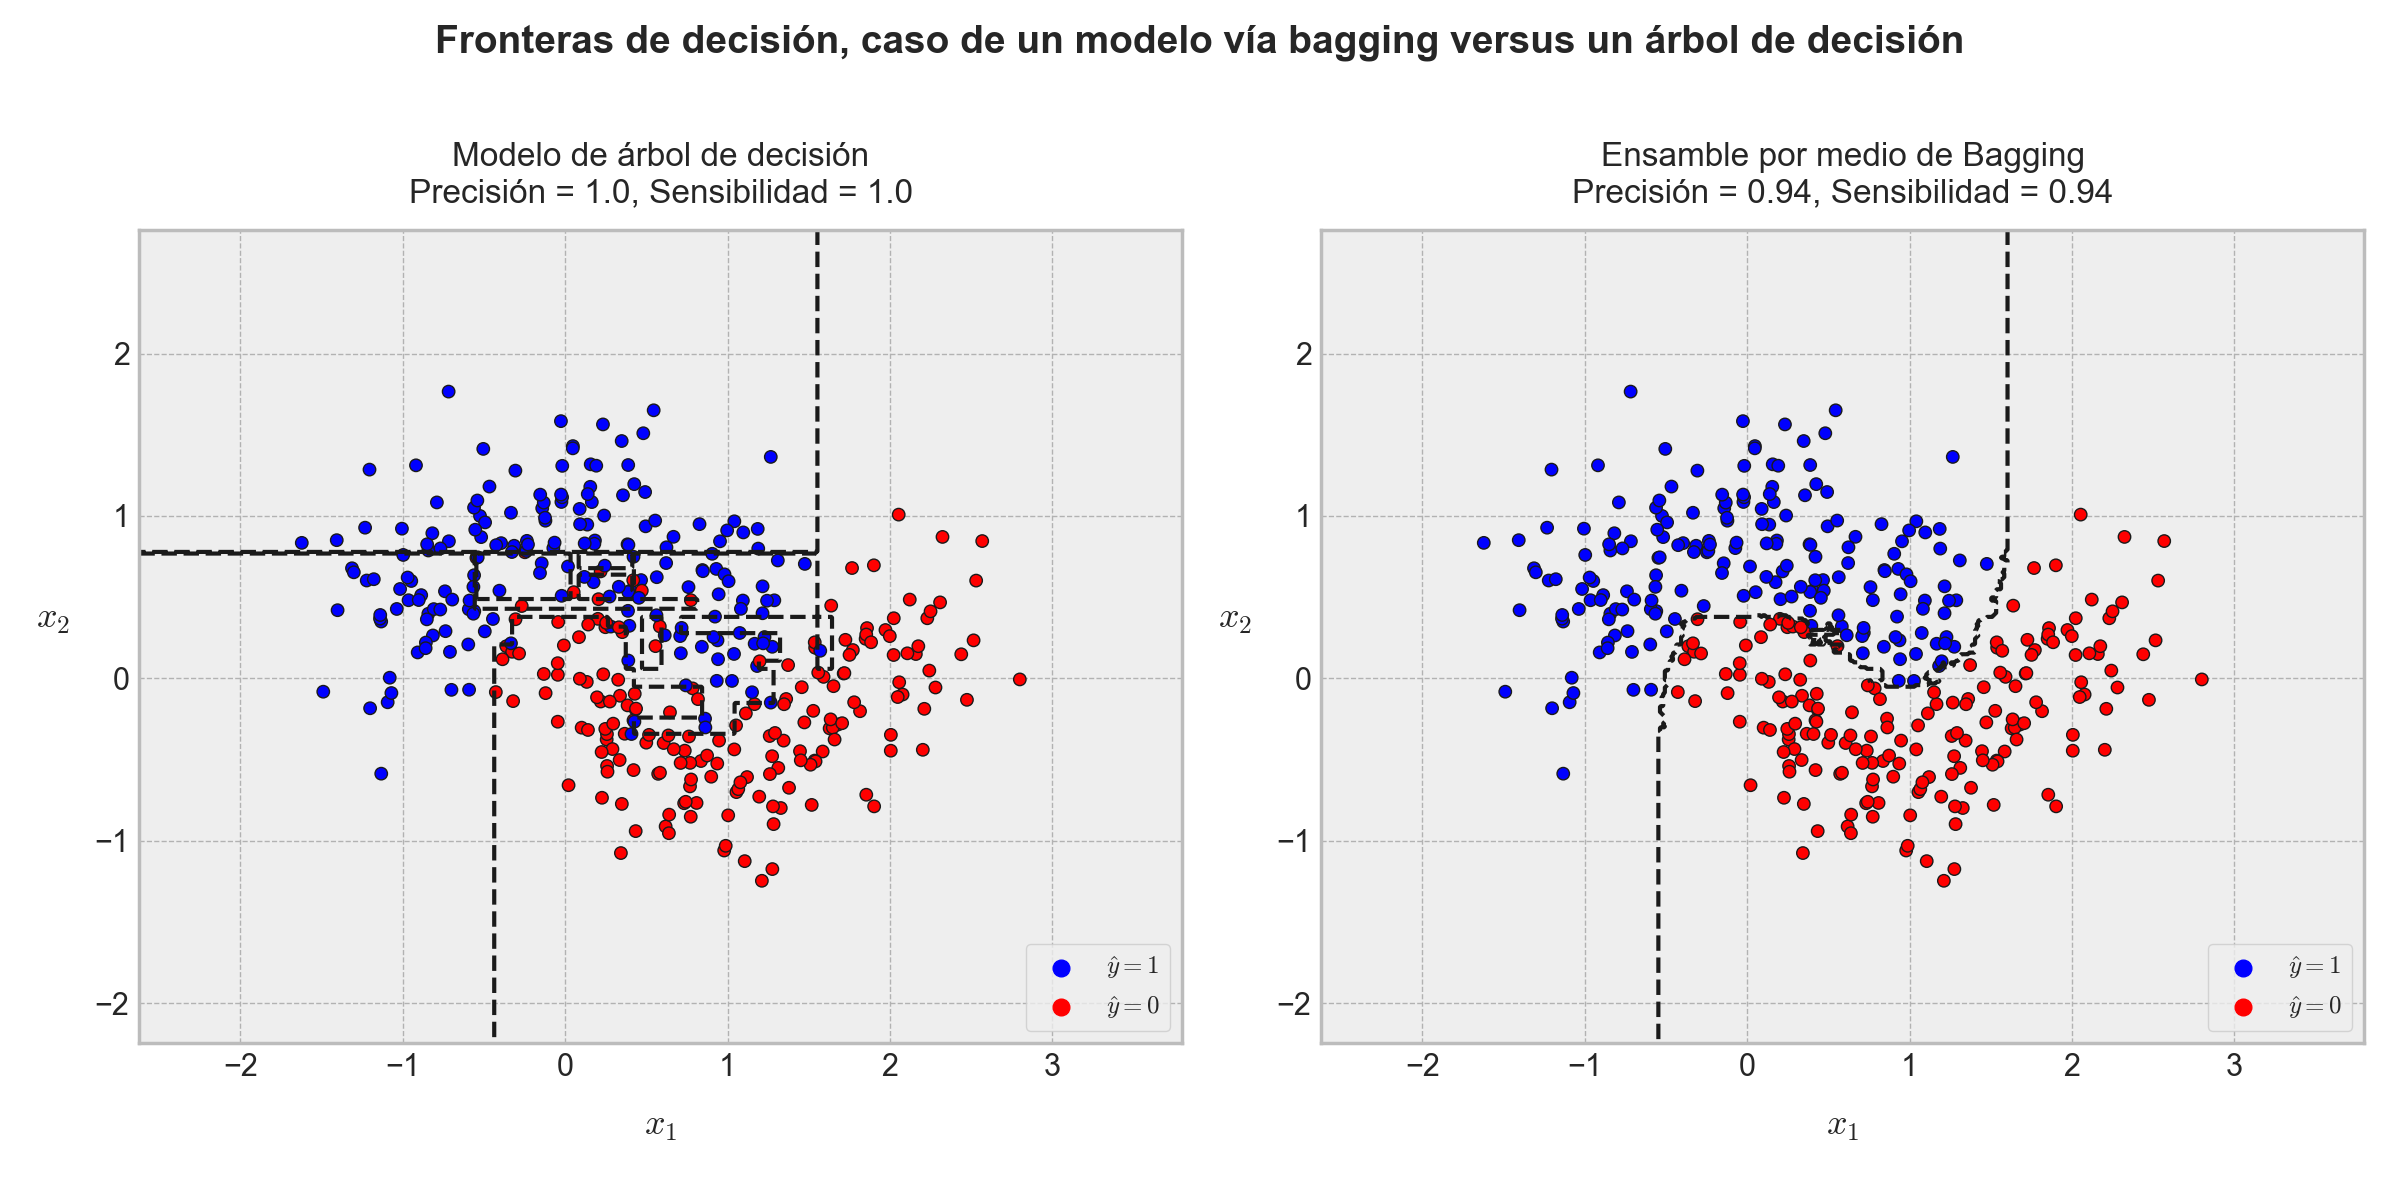

In [60]:
# Generamos un reporte gráfico de nuestros resultados.
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
fig.suptitle(
    "Fronteras de decisión, caso de un modelo vía bagging versus un árbol de decisión", 
    fontsize=14, fontweight="bold",
)
# Creamos una grilla de puntos en las cuales evaluaremos nuestros modelos.
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
X1, X2 = np.meshgrid(
    np.arange(start=x1_min, stop=x1_max, step=0.01), 
    np.arange(start=x2_min, stop=x2_max, step=0.01),
)
# Generamos las correspondientes predicciones.
Z_ensemble = bagging_model.predict(np.c_[X1.ravel(), X2.ravel()])
Z_tree = tree_model.predict(np.c_[X1.ravel(), X2.ravel()])
Z_ensemble = Z_ensemble.reshape(X1.shape)
Z_tree = Z_tree.reshape(X1.shape)
y_pred_train_ensemble = bagging_model.predict(X_train)
y_pred_train_tree = tree_model.predict(X_train)
y_pred_test_ensemble = bagging_model.predict(X_test)
y_pred_test_tree = tree_model.predict(X_test)

# Evaluamos los modelos en los datos de prueba.
precision_ensemble = precision_score(y_train, y_pred_train_ensemble)
precision_tree = precision_score(y_train, y_pred_train_tree)
recall_ensemble = recall_score(y_train, y_pred_train_ensemble)
recall_tree = recall_score(y_train, y_pred_train_tree)

# Graficamos las fronteras de decisión con respecto a nuestro dataset.
ax[0].scatter(
    X_train[:, 0], X_train[:, 1], c=y_pred_train_tree, cmap="bwr", 
    edgecolors='k', s=20,
)
ax[0].scatter(x=None, y=None, c="blue", label=r"$\hat{y}=1$")
ax[0].scatter(x=None, y=None, c="red", label=r"$\hat{y}=0$")
ax[0].contour(
    X1, X2, Z_tree, levels=[0.5], colors='k', linestyles='--', linewidths=1.5,
)
ax[0].legend(loc="lower right", fontsize=9, frameon=True)
ax[0].set_xlabel(r"$x_{1}$", fontsize=13, labelpad=10)
ax[0].set_ylabel(r"$x_{2}$", fontsize=13, labelpad=15, rotation=0)
ax[0].set_title(
    "Modelo de árbol de decisión"
    + "\n" + f"Precisión = {round(precision_tree, 2)}, Sensibilidad = {round(recall_tree, 2)}",
    fontsize=12, pad=10,
)
ax[0].set_aspect('equal', adjustable='box')
ax[1].scatter(
    X_train[:, 0], X_train[:, 1], c=y_pred_train_ensemble, cmap="bwr", 
    edgecolors='k', s=20,
)
ax[1].scatter(x=None, y=None, c="blue", label=r"$\hat{y}=1$")
ax[1].scatter(x=None, y=None, c="red", label=r"$\hat{y}=0$")
ax[1].contour(
    X1, X2, Z_ensemble, levels=[0.5], colors='k', linestyles='--', linewidths=1.5,
)
ax[1].legend(loc="lower right", fontsize=9, frameon=True)
ax[1].set_xlabel(r"$x_{1}$", fontsize=13, labelpad=10)
ax[1].set_ylabel(r"$x_{2}$", fontsize=13, labelpad=15, rotation=0)
ax[1].set_title(
    "Ensamble por medio de Bagging"
    + "\n" + f"Precisión = {round(precision_ensemble, 2)}, Sensibilidad = {round(recall_ensemble, 2)}",
    fontsize=12, pad=10,
)
ax[1].set_aspect('equal', adjustable='box')
plt.tight_layout();

Como podemos observar, las predicciones del ensamble presentan un sesgo más o menos similar a las realizadas por el modelo de árbol de decisión, pero con una varianza menor, lo que garantiza una mejor generalización de la información aprendida y, por extensión, una menor propensión al overfitting (comete los mismos errores, pero la frontera de decisión es indudablemente mucho más regular).

La implementación de bootstrapping introduce un poco más de diversidad en los subconjuntos sobre los cuales se entrena cada predictor, por lo cual el procedimiento de bagging presenta un mayor sesgo que el muestreo sin reemplazo (que en ciertos textos especializados se denomina **pasting**). Pero esta diversidad también implica que los predictores estarán menos correlacionados los unos con los otros, por lo que la varianza del ensamble se reduce significativamente. En términos globales, la implementación de un procedimiento de bagging produce modelos mejores que los obtenidos vía pasting, e indudablemente resulta mucho mejor que la aplicación de modelos menos no colectivos, lo que explica por qué esta estrategia tiene mayor preferencia en el mercado. Sin embargo, si contamos con el poder de procesamiento necesario (y el tiempo), podemos utilizar validación cruzada mediante bagging y pasting, y así seleccionar el modelo que mejor funcione en cada caso.

Como pedimos que en entrenamiento de nuestro modelo incluyera la evaluación de instancias OOB a modo de validación, podemos igualmente consultar el correspondiente error sobre tales instancias, a fin de verificar que tan bien generaliza nuestro modelo sin tener que recurrir para ello a los datos de prueba. Tal error, en modelos de clasificación, corresponde a su exactitud:

In [61]:
# Mostramos en pantalla el error de generalización del modelo sobre instancias OOB.
print(f"Error de generalización basado en evaluación de instancias OOB = {round(bagging_model.oob_score_, 3)}")

Error de generalización basado en evaluación de instancias OOB = 0.925


Y ahí lo tenemos. Este valor aparentemente es bastante bueno, aunque como siempre, requerirá de un *doble click* conforme los objetivos (de negocio, ojalá) inherentes a la resolución del problema de interés.

La **función de decisión** de un modelo evaluado con instancias tipo OOB está disponible en el atributo `oob_decision_function_`. En este caso (dado que el predictor base dispone de un método `predict_proba()`, que efectivamente estima probabilidades de pertenencias a cada clase), la función de decisión retorna las probabilidades de clase para cada una de las instancias que componen nuestro conjunto de entrenamiento. Por ejemplo, la evaluación de instancias OOB estima que la primera instancia de entrenamiento tiene una probabilidad del 35.58% de pertenecer a la clase positiva (y un 64,42% de pertenecer a la clase negativa):

In [62]:
# Mostramos las probabilidades calculadas por la función de decisión para las primeras 5 instancias.
probas = bagging_model.oob_decision_function_
probas[:5, :]

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.01030928, 0.98969072],
       [0.03174603, 0.96825397]])

A modo ilustrativo, visualizaremos estas probabilidades en un gráfico, a fin de observar cómo éstas varían a lo largo de la frontera de decisión:

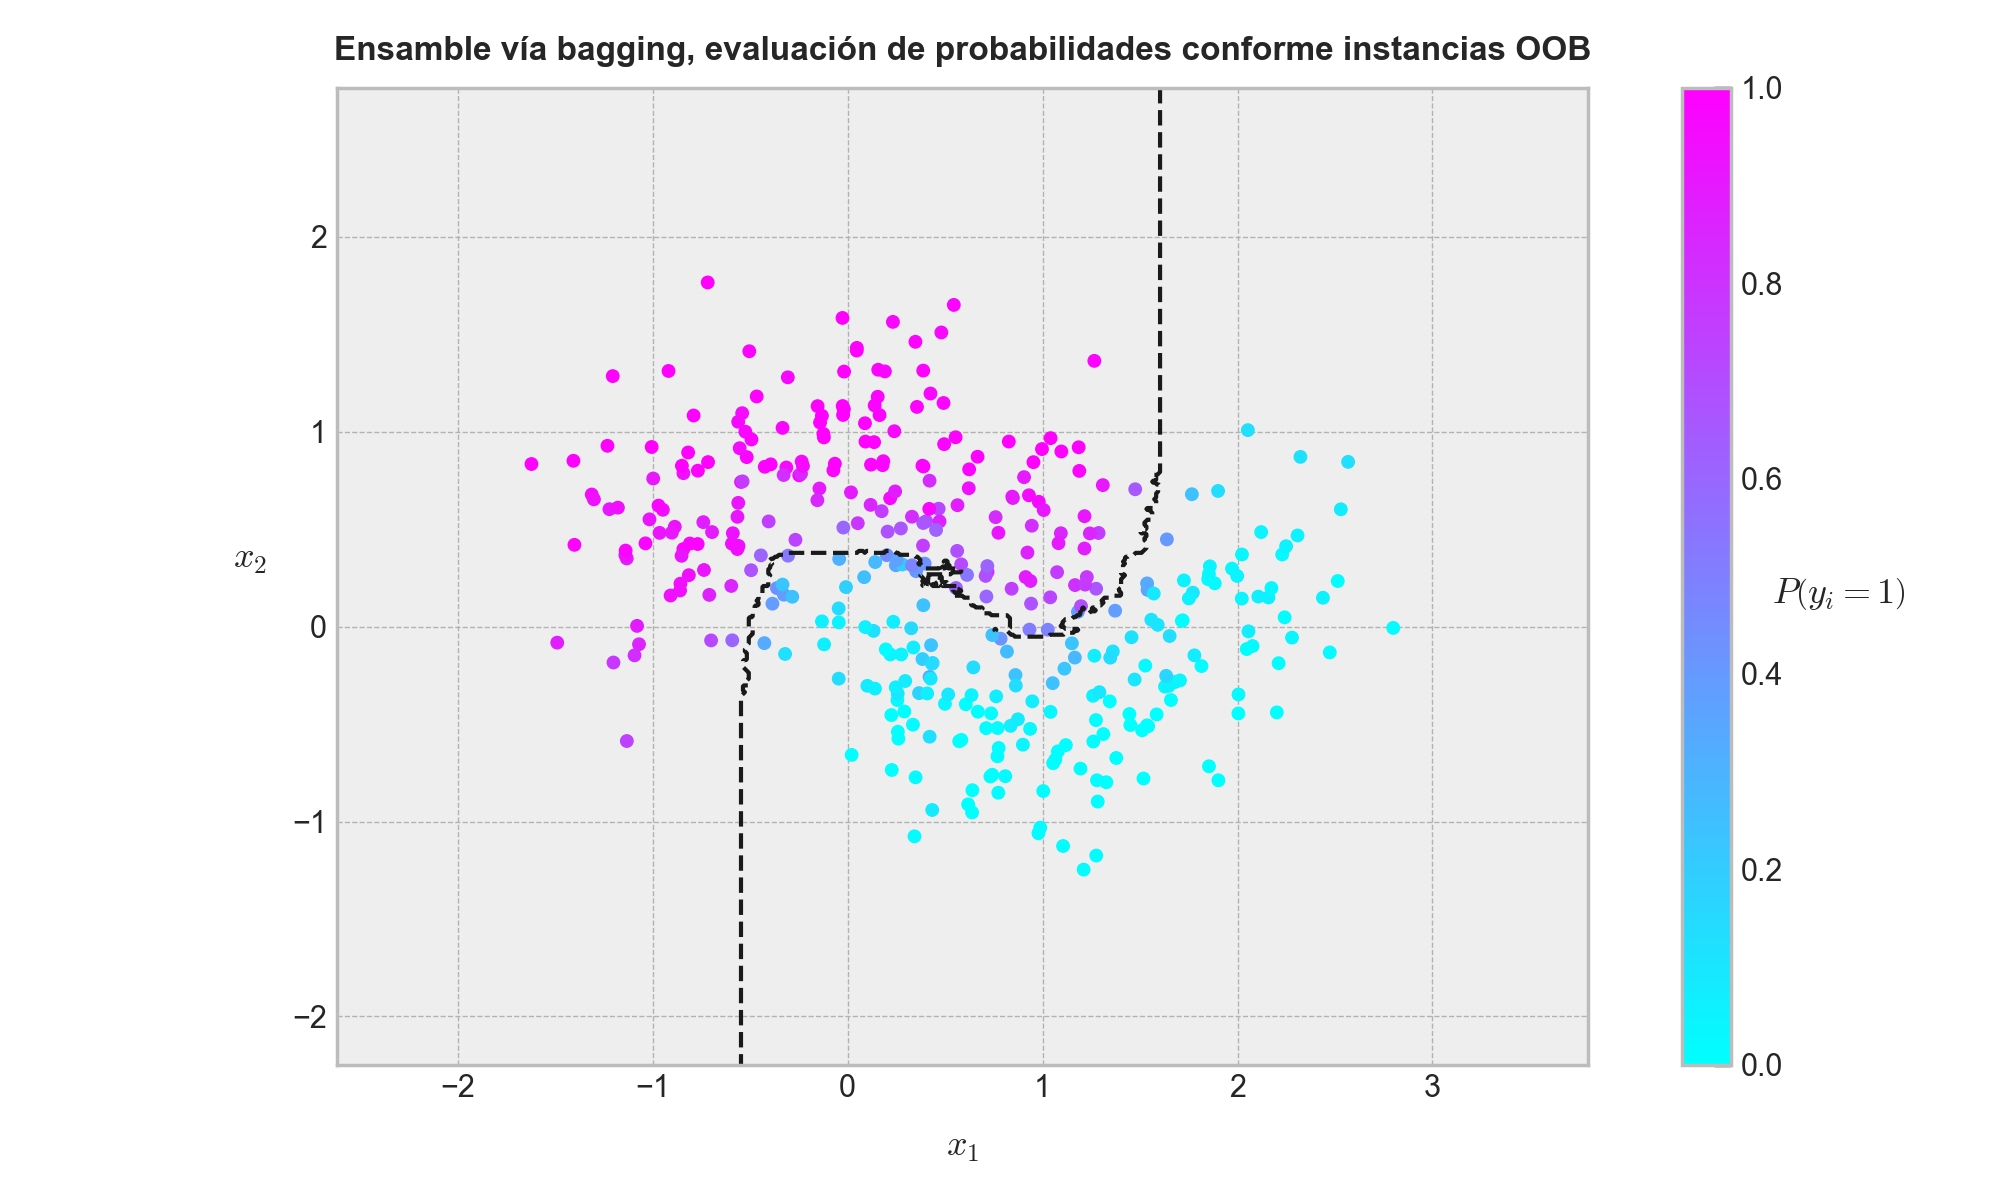

In [63]:
# Generamos un reporte gráfico de nuestros resultados.
fig, ax = plt.subplots(figsize=(10, 6))
p = ax.scatter(
    X_train[:, 0], X_train[:, 1], c=probas[:, 0], 
    cmap="cool", s=20,
)
ax.scatter(x=None, y=None, c="blue", label=r"$\hat{y}=1$")
ax.scatter(x=None, y=None, c="red", label=r"$\hat{y}=0$")
ax.contour(
    X1, X2, Z_ensemble, levels=[0.5], colors='k', linestyles='--', linewidths=1.5,
)
cb = fig.colorbar(p)
ax.set_xlabel(r"$x_{1}$", fontsize=13, labelpad=10)
ax.set_ylabel(r"$x_{2}$", fontsize=13, labelpad=15, rotation=0)
ax.set_title(
    "Ensamble vía bagging, evaluación de probabilidades conforme instancias OOB",
    fontsize=12, fontweight="bold", pad=10,
)
cb.set_label(r"$P\left( y_{i}=1 \right)$", fontsize=13, labelpad=20, rotation=0)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout();